# Project CovidSense

This notebook seeks to analyze first order statistics of the covidsense data.

In [68]:
# System imports
import os
import sys
import time
import pickle
import glob
from tqdm import tqdm
from collections import Counter
import datetime
import pdb
import pprint

# Geocoder to deal with uncertain location strings
import geocoder
import pycountry
import phonenumbers
from phonenumbers import carrier
import phonenumbers.geocoder as ph_geocoder
import folium

# Scientific computing
import numpy as np
from scipy import stats
import pandas as pd

# JSON
import json

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# Custom modules
import psychometry
#import parser_old as parser
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
plt.rcParams.update({'font.size': 15})
style.use('seaborn-paper') #sets the size of the charts
style.use('ggplot')

bg_color = (0.96862745, 0.96862745, 0.96862745)
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')


In [69]:
# We will require repeated reloads of the parser
import importlib
parser = importlib.reload(parser)

In [70]:
if __name__ == '__main__':
    root = 'data/responses_normalized'
    geocoder_cache_name = 'data/geocoder_cache.json'
    rubriks_dir = 'CE-EmaResponseValidator/data/json'
    db_name = 'data/covidsense_db.json'
    keys_name = 'data/covidsense_keys.json'
    sms_intent_name = 'data/transmitted_sms_intents.json'
    texas_cases_name = 'data/Texas_cases.json'
    
    us_state_codes_name = 'data/states.csv'
    us_state_gov_name = 'data/states_gov.csv'
    us_state_region_name = 'data/states_regions.csv'
    us_state_geojson_name = 'data/us-states.json'
    country_geojson_name = 'data/world-countries.json'
    
    # Load all rubriks
    rubriks = dict()
    rubrik_files = glob.glob('%s/*.json'%rubriks_dir)
    
    for filename in tqdm(rubrik_files):
        with open(filename, 'rb') as f:
            survey_id = os.path.split(filename)[1].replace('.json', '')
            rubriks[survey_id] = json.load(f)
    
    # Create a JSON file to store geocoder cache
    if os.path.exists(geocoder_cache_name):
        geocoder_cache = json.load(open(geocoder_cache_name, 'rb'))
    else:
        print('Initiating geocoder cache')
        geocoder_cache = dict()
        
    # Load rubriks for psychometric tests
    qids_rubrik = json.load(open('data/c.json', 'rb'))
    ipip_rubrik = json.load(open('data/d.json', 'rb'))
    camsr_rubrik = json.load(open('data/e.json', 'rb'))

    # Get all files
    filenames = glob.glob('%s/*'%root)
    
    # Some are test files and others need to be ignored
    filenames = [filename for filename in filenames if\
                 '1x424' not in filename and\
                 '1x214284' not in filename]

    print('Found %d respones'%len(filenames))
    
    # Create a participant dictionary
    participant_dict = dict()
    PID = 0
    
    # Create hash table to store information about participants
    participant_keys = dict()

    # Since we can get state data now, we can do statistics per state
    # Convert state names to abbreviations
    with open(us_state_codes_name, 'r') as f:
        states_data = f.readlines()
    
    with open(us_state_gov_name, 'r') as f:
        gov_data = f.readlines()
        
    with open(us_state_region_name, 'r') as f:
        region_data = f.readlines()
        
    name2code = dict()
    name2gov = dict()
    name2region = dict()
        
    for state in states_data:
        name, code = state.strip().replace(r'"', '').split(',')
        name2code[name] = code
        
    for state in gov_data:
        name, gov = state.strip().replace(r'"', '').split(',')
        name2gov[name] = gov
        
    for state in region_data:
        name, region = state.strip().replace(r'"', '').split(',')
        name2region[name] = region
    
    # Load geojson data
    with open(us_state_geojson_name, 'rb') as f:
        states_geojson = json.load(f)
        
    with open(country_geojson_name, 'rb') as f:
        countries_geojson = json.load(f)
        
    # Load texas cases file
    with open(texas_cases_name, 'rb') as f:
        texas_cases = json.load(f)
        texas_pd = pd.DataFrame.from_dict(texas_cases)

100%|██████████| 46/46 [00:00<00:00, 3946.21it/s]


Found 14487 respones


In [71]:
    parser = importlib.reload(parser)
    for idx in tqdm(range(len(filenames))):
        data = json.load(open(filenames[idx], 'rb'))
        data_copy = data.copy()
        
        cell_number = data['emaDirective']['recipientMobileNumber']
        paneltype = data['emaDirective']['panel']
        
        _, version = data['httpRequest']['requestBodyJson']['surveyId'].split('-')
        survey_id = data['httpRequest']['surveyId']
        
        if cell_number in participant_keys.keys():
            participant_dict[participant_keys[cell_number]]['nresponses'] += 1
        else:
            participant_dict['P%d'%PID] = parser.new_participant(PID)
            participant_keys[cell_number] = 'P%d'%PID
            PID += 1
        
        # Get current PID string
        PIDc = participant_keys[cell_number]
        
        # Rely on file name instead of creationMomentUnixTimeMs
        
        #time_epoch = data['emaDirective']['creationMomentUnixTimeMs']
        time_epoch = int(os.path.split(filenames[idx])[1].split('-')[1].replace('.normal', ''))
        time_stamp = datetime.datetime.fromtimestamp(time_epoch/1000.0)
        
        # We can estimate attrition rate by checking last estimated time stamps
        participant_dict[PIDc]['timestamps'].append(time_epoch)
        participant_dict[PIDc]['panels'].append(paneltype)
        participant_dict[PIDc]['survey_ids'].append(survey_id)
        
        responses = data['httpRequest']['requestBodyJson']
        
        # Clean up and create info dictionary
        responses_cleaned = parser.autoclean(responses.copy(), rubriks[survey_id])
        info = parser.parse(responses_cleaned, rubriks[survey_id], survey_id)
        
        if paneltype == 'C':
            # QIDS psychometric test
            c_resp = responses
            score = psychometry.QIDS(responses, qids_rubrik)
            participant_dict[PIDc]['QIDS'][time_epoch] = score
                
        if paneltype == 'D':            
            score = psychometry.IPIP(responses, ipip_rubrik)
            participant_dict[PIDc]['IPIP'] = score
            
        if paneltype == 'E':
            # CAMS-R test
            e_resp = responses
            
            score = psychometry.CAMS_R(responses, camsr_rubrik)
            participant_dict[PIDc]['CAMS-R'] = score
            
        # Adhoc approach of estimating occupation
        occupation = parser.crude_job(paneltype)
        if occupation is not None:
            participant_dict[PIDc]['occupation'] = occupation
        
        if paneltype == 'S':    
            # S panel is same as registration time
            participant_dict[PIDc]['reg_time'] = time_epoch
            
            for key in info:
                participant_dict[PIDc][key] = info[key]
                
            # Extract information about location in a stratified manner
            country, geocoder_cache = parser.get_country(data['httpRequest']['requestHeaders'],
                                                         info['location'], cell_number,
                                                         geocoder_cache)
            
            participant_dict[PIDc]['country'] = country
            
            # Now, store state info too
            state, geocoder_cache = parser.get_state(info['location'], geocoder_cache)
            
            if state is not None:
                participant_dict[PIDc]['state'] = state
            
            # QIDS
            qids_dict = parser.info2qids(info, rubriks['C-1-0'])
            qids_score = psychometry.QIDS(qids_dict, qids_rubrik)
                
            participant_dict[PIDc]['QIDS'][time_epoch] = qids_score
            
            # CAMS-R
            if 'camsr1' in info:
                camsr_dict = parser.info2camsr(info, rubriks['E-1-0'])
                camsr_score = psychometry.CAMS_R(camsr_dict, camsr_rubrik)
                
            participant_dict[PIDc]['CAMS-R'] = camsr_score
            
            # IPIP
            
        if paneltype in 'AVPMI':
            info = parser.parse(responses, rubriks[survey_id], survey_id)
            info['time'] = time_epoch
            
            if survey_id in ['A-4-0', 'A-6-0']:
                d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')
                
                # QIDS
                qids_dict = parser.info2qids(info, rubriks['C-1-0'])
                qids_score = psychometry.QIDS(qids_dict, qids_rubrik)
                
                participant_dict[PIDc]['QIDS'][time_epoch] = qids_score
            
            participant_dict[PIDc][paneltype].append(info)

100%|██████████| 14487/14487 [02:07<00:00, 113.43it/s]


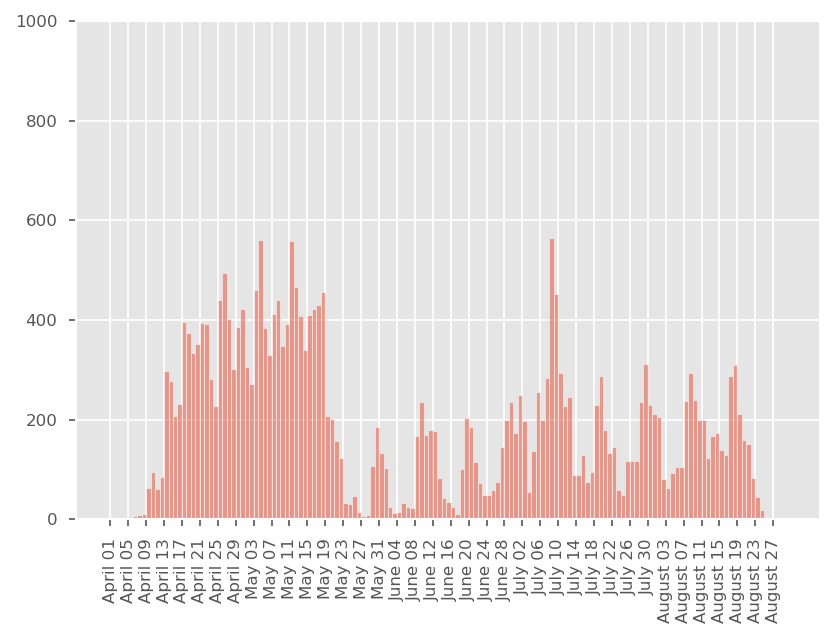

In [72]:
    # Load and process all intents

    bins = []
    for month in [4, 5, 6, 7, 8]:
        if month%2 == 0:
            days = 30
        else:
            days = 31
        for day in range(1, days+1):
            bins.append(datetime.datetime(2020, month, day, 0, 0).timestamp()*1000)
            
    with open(sms_intent_name, 'rb') as f:
        intents_data = json.load(f)
    
    intents = []
    for intent in intents_data['activeSmsIntents']:
        intents.append(intent['sendWhenUnixTimeMs'])
        try:
            participant_dict[participant_keys[intent['to']]]['intents'].append(intent['sendWhenUnixTimeMs'])
        except KeyError:
            pass
    
    labels = [d2s(timestamp) for timestamp in bins]
    fig = plt.figure(dpi=150)
    plt.hist(intents, bins=bins, ec='white', alpha=0.5)
    plt.ylim([0, 1000])
    plt.xticks(bins[::4], labels=labels[::4], rotation='vertical')
    plt.show()

In [73]:
    utils = importlib.reload(utils)

    # First, store the cache
    with open(geocoder_cache_name, 'w') as write_file:
        json.dump(geocoder_cache, write_file)
        
    # Then store the anonymized data as well as keys
    with open(db_name, 'w') as write_file:
        json.dump(participant_dict, write_file)
        
    with open(keys_name, 'w') as write_file:
        json.dump(participant_keys, write_file)

    # Convert to numpy arrays to simplify analysis
    survey_ids = np.array(utils.cat_arrays(participant_dict, 'survey_ids'))
    time_stamps = np.array(utils.cat_arrays(participant_dict, 'timestamps'))
    ages = np.array([participant_dict[key]['age'] for key in participant_dict])
    genders = np.array([participant_dict[key]['gender'] for key in participant_dict])
    countries = [participant_dict[key]['country'] for key in participant_dict]
    
    # Now continue with metrics
    unique_participants = len(participant_dict)
    n_responses = len(survey_ids)

    unique_surveys = Counter(survey_ids).keys()

    print('%d unique correspondents'%unique_participants)
    print('%d surveys conducted'%len(unique_surveys))

    n_health_workers = len([key for key in participant_dict if \
                            participant_dict[key]['healthcare_worker'] == 'Yes'])
    
    n_caretakers = len([key for key in participant_dict if \
                       len(participant_dict[key]['M']) > 0])
    
    n_covid = len([key for key in participant_dict if \
                  len(participant_dict[key]['I']) > 0])

    print('%d health workers registered'%n_health_workers)
    print('%d caretakers registered'%n_caretakers)
    print('%d suspected, current, or previous COVID'%n_covid)


1177 unique correspondents
44 surveys conducted
308 health workers registered
37 caretakers registered
82 suspected, current, or previous COVID


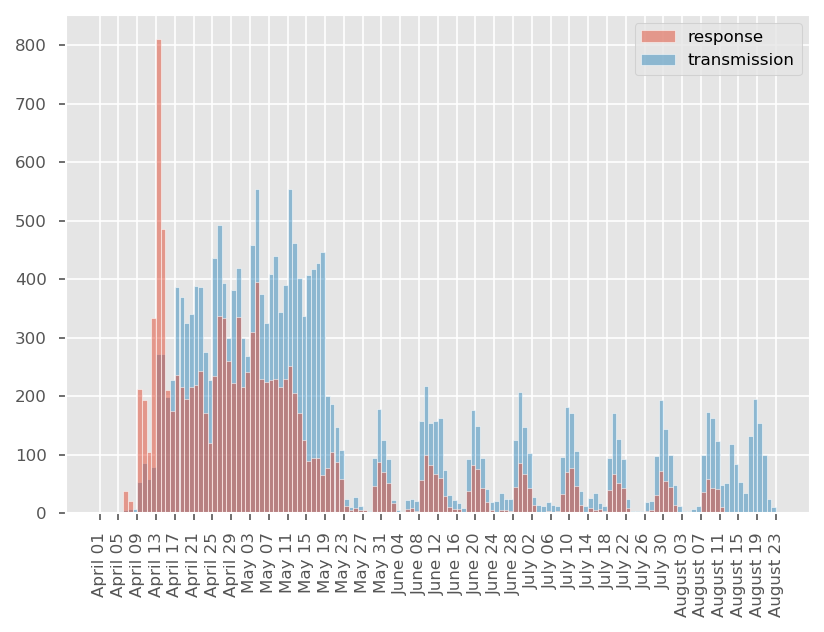

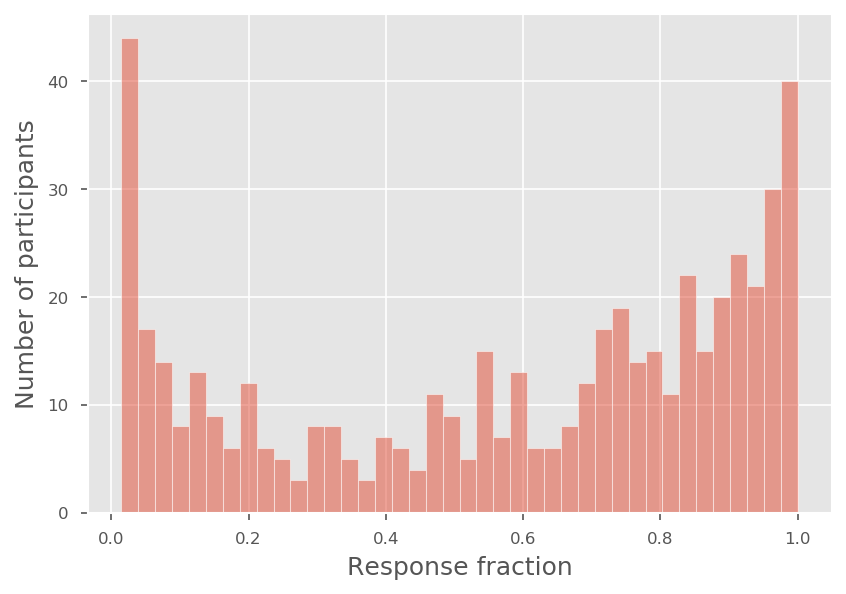

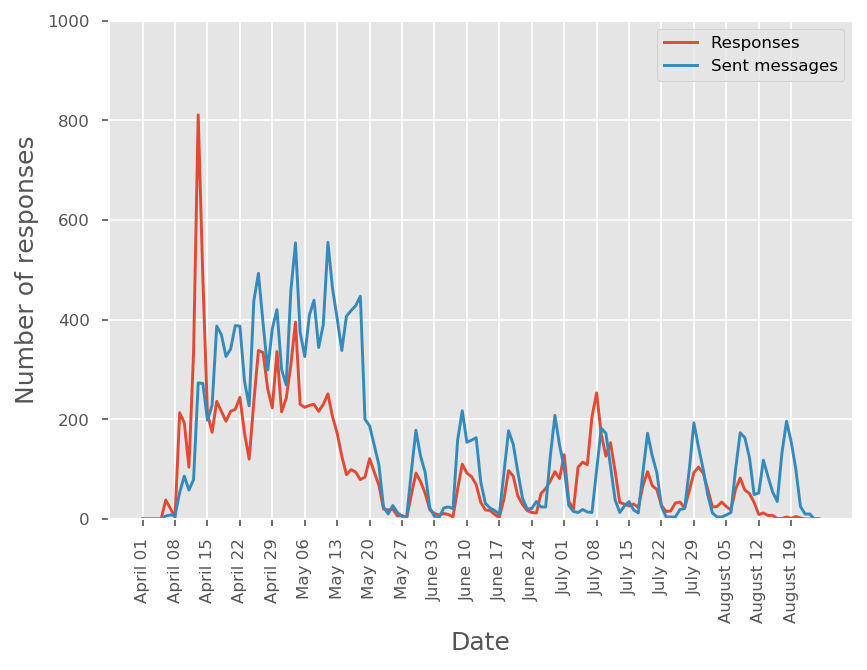

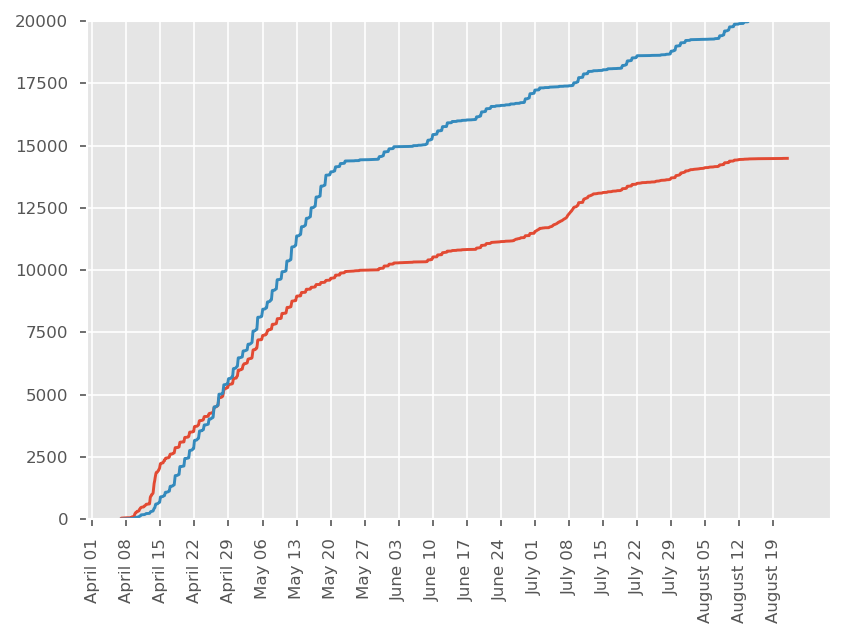

In [74]:
    
    epoch1 = 24*3600*(datetime.datetime(2020, 4, 1, 0, 0).timestamp()//(24*3600))
    epoch2 = 24*3600*(int(datetime.date.today().strftime('%s'))//(24*3600))
    #epoch2 = 24*3600*(datetime.datetime(2020, 6, 22, 0, 0).timestamp()//(24*3600))
    
    epochs = np.arange(epoch1, epoch2 + 60*60*24+1, 60*60*24, dtype=int)
    
    reg_limit = int(datetime.datetime(2020, 5, 16, 0, 0).timestamp())*1000
    
    old_dict = {key:participant_dict[key] for key in participant_dict if participant_dict[key]['reg_time'] < reg_limit}
    
    bins = np.arange(epoch1, epoch2, 24*3600)*1000
    
    fig = plt.figure(dpi=150)
    plt.hist(utils.cat_arrays(old_dict, 'timestamps'), bins=bins, ec='white', alpha=0.5, zorder=2, label='response')
    plt.hist(utils.cat_arrays(old_dict, 'intents'), bins=bins, ec='white', alpha=0.5, zorder=1, label='transmission')
    plt.xticks(bins[::4], labels=[d2s(b) for b in bins[::4]], rotation='vertical')
    plt.legend()
    plt.show()
    
    # Plot number of responses and intents as a function of time
    #response_times = np.array(utils.cat_arrays(participant_dict, 'timestamps'))
    
    # Get raw response times from filenames itself
    response_times = [int(os.path.split(filename)[1].split('-')[1].replace('.normal', ''))\
                               for filename in filenames]
    response_times = np.array([response_time for response_time in response_times if response_time < epoch2*1000])
    
    panels = np.array(utils.cat_arrays(old_dict, 'panels'))
    
    intent_times = utils.cat_arrays(old_dict, 'intents')
    intent_times = np.array([intent_time for intent_time in intent_times if intent_time < epoch2*1000])
    
    response_fraction = [len(old_dict[key]['panels'])/len(old_dict[key]['intents']) \
                         for key in old_dict if len(old_dict[key]['intents']) > 0]
    keys = [key for key in old_dict if len(old_dict[key]['intents']) > 0]
    
    response_fraction = np.array(response_fraction)
    
    if True:
        fig = plt.figure(dpi=150)
        plt.hist(response_fraction, ec='white', alpha=0.5, bins=40)
        plt.xlabel('Response fraction')
        plt.ylabel('Number of participants')

        responses_dict = {epoch:0 for epoch in epochs}
        intents_dict = {epoch:0 for epoch in epochs}

        for response_time in response_times:
            responses_dict[24*3600*(response_time//(24*3600*1000))] += 1

        for intent_time in intent_times:
            try:
                intents_dict[24*3600*(intent_time//(24*3600*1000))] += 1
            except KeyError:
                pass

        fig = plt.figure(dpi=150)
        plt.plot(list(responses_dict.keys()), list(responses_dict.values()), label='Responses')
        plt.plot(list(intents_dict.keys()), list(intents_dict.values()), label='Sent messages')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Number of responses')
        plt.xticks(epochs[::7], labels=[d2s(epoch*1000) for epoch in epochs[::7]], rotation='vertical')
        plt.ylim([0, 1000])
        plt.show()

        t2 = dict()
        t3 = dict()

        for response_time in response_times:
            try:
                t2[3600*(response_time//(3600*1000))] += 1
            except KeyError:
                t2[3600*(response_time//(3600*1000))] = 1

        for intent_time in intent_times:
            try:
                t3[3600*(intent_time//(3600*1000))] += 1
            except KeyError:
                t3[3600*(intent_time//(3600*1000))] = 1

        fig = plt.figure(dpi=150)
        keys = np.array(list(t2.keys()))
        vals = np.array(list(t2.values()))

        indices = np.argsort(keys)

        plt.plot(keys[indices], np.cumsum(vals[indices]), label='Responses')
        keys = np.array(list(t3.keys()))
        vals = np.array(list(t3.values()))

        indices = np.argsort(keys)
        plt.plot(keys[indices], np.cumsum(vals[indices]), label='Sent messages')
        plt.ylim([0, 20000])
        plt.xticks(epochs[::7], labels=[d2s(epoch*1000) for epoch in epochs[::7]], rotation='vertical')
        plt.show()
        
        #print(d2s(keys[np.argmax(vals)]*1000))
        #print(vals.max())


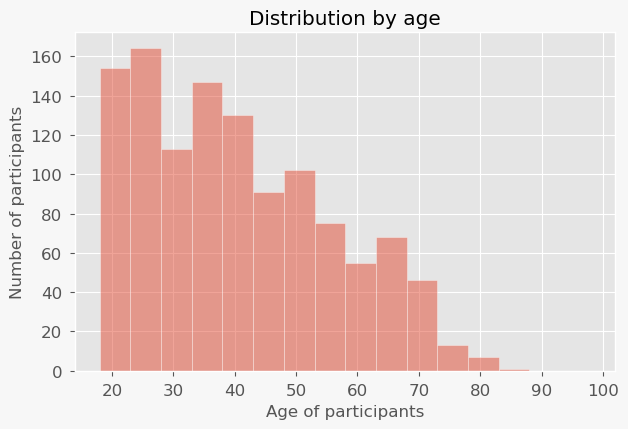

10
[18 23 28 33 38 43 48 53 58 63 68 73 78 83 88 93 98]
['Ri, , ', ', NW, ', ', TX, ', 'La, , ', 'Se, , ', 'Sy, , ', ', Na, ', 'Ba, , ', ', Na, ', 'Ev, , ', 'MD, , ', 'Mu, , ', 'NB, , ']


In [91]:
    # Try plotting distribution of participants by age
    
    fig1 = plt.figure(dpi=100)
    fig1.patch.set_facecolor(bg_color)
    bins = np.arange(18, 100, 5)
    n, bins, patches = plt.hist(ages[ages > 0], ec='white', bins=bins, alpha=0.5)
    plt.xlabel('Age of participants', fontsize=12)
    plt.ylabel('Number of participants', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Distribution by age')
    plt.tight_layout()
    plt.show()
    
    print((ages < 18).sum())
    print(bins)
    
    print([participant_dict[key]['location'] for key in participant_dict \
           if len(participant_dict[key]['location']) == 6])

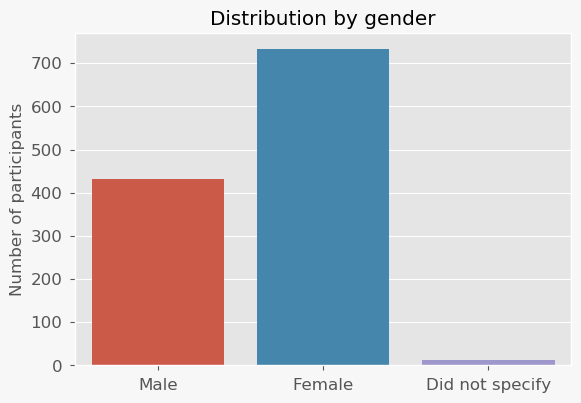

In [75]:
    # Distribution by gender
    genders = utils.getall(participant_dict, 'gender')
    g_counter = {'Male': 0, 'Female': 0, 'Did not specify': 0}
    
    for gender in genders:
        if gender == 'male':
            g_counter['Male'] += 1
        elif gender == 'female':
            g_counter['Female'] += 1
        else:
            g_counter['Did not specify'] += 1
    
    fig = plt.figure(dpi=100)
    fig.patch.set_facecolor(bg_color)
    handle = sns.barplot(list(g_counter.keys()), list(g_counter.values()))
    plt.ylabel('Number of participants', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Distribution by gender')
    plt.show()
    

In [ ]:
    # What if we coplot age and responses?
    with sns.axes_style("white"):
        handle = sns.jointplot(ages, nresponses_array, kind='hex')
        handle.set_axis_labels('Participant age', 'Number of responses', fontsize=20)
        plt.tight_layout()

In [ ]:
    # Plot pie chart for contribution of various nationalities
    nationalities = ['USA', 'India', 'Canada', 'Could not locate']
    n_nationalities = [n_usa, n_india, n_canada, n_others]
    explode = [0.1, 0.1, 0.1, 0.1]

    handle = sns.barplot(nationalities, n_nationalities)
    handle.set_xlabel('Country', fontsize=20)
    handle.set_ylabel('Number of participants', fontsize=20)
    plt.tight_layout()
        

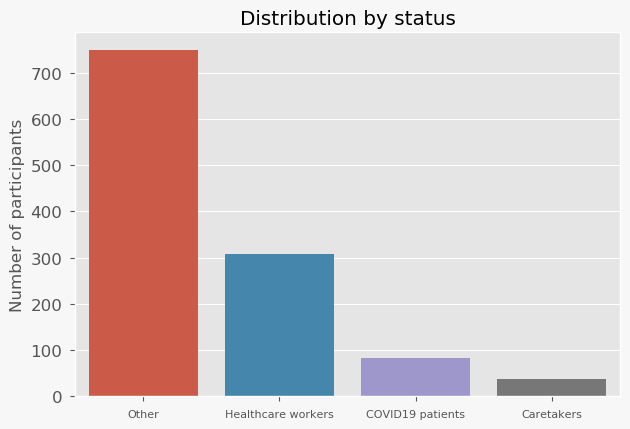

In [94]:
    # Now for distribution of nature of participants
    fig6 = plt.figure(6, dpi=100)
    fig6.patch.set_facecolor(bg_color)
    n_total = unique_participants
    n_others = n_total - n_health_workers - n_covid - n_caretakers
    occupation = [n_others, n_health_workers, n_covid, n_caretakers]
    labels = ['Other', 'Healthcare workers', 'COVID19 patients', 'Caretakers']
    
    handle = sns.barplot(labels, occupation)
    #handle.set_xlabel('Occupation', fontsize=12)
    handle.set_ylabel('Number of participants', fontsize=12)
    plt.title('Distribution by status')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=12)
    plt.tight_layout()

Counter({'US': 639,
         'IN': 241,
         'ZA': 123,
         'GB': 77,
         'MX': 45,
         'LB': 20,
         'BR': 9,
         'CA': 4,
         'DE': 3,
         'TH': 2,
         'PR': 2,
         'AU': 2,
         'ES': 1,
         'BA': 1,
         'FR': 1,
         'SG': 1,
         'IE': 1,
         'PL': 1,
         'GR': 1,
         'EG': 1,
         'PT': 1,
         'QA': 1})
1594428417175
['US', 'GB', 'IN', 'ZA', 'BR', 'MX']
[1.50442478 2.67605634 1.98863636 0.56910569 7.77777778 1.55555556]


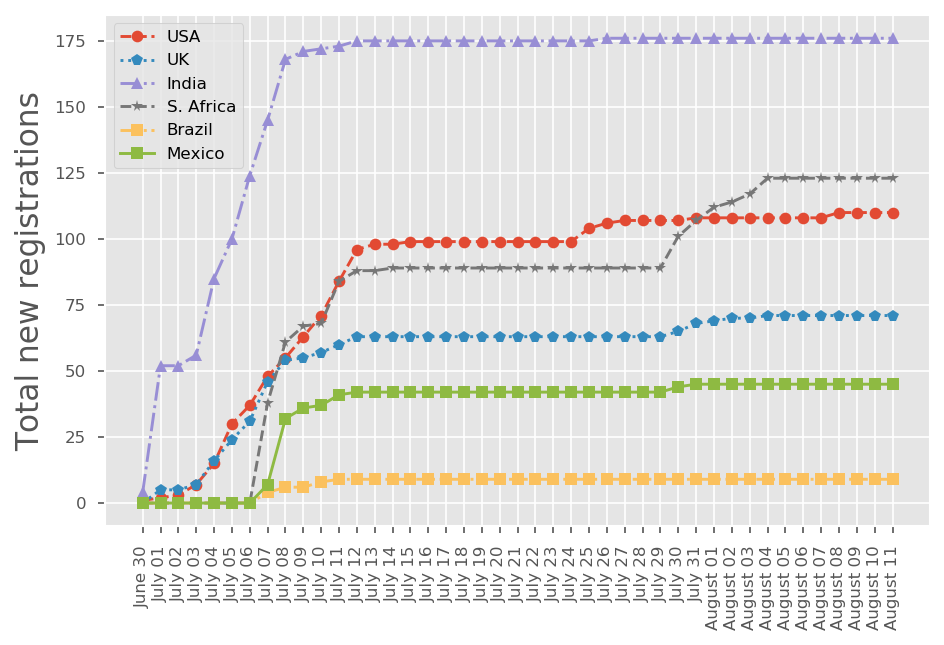

In [76]:
    # Plot number of registrations per time stamp
    
    #country = 'GB'
    countries = ['US', 'GB', 'IN', 'ZA', 'BR', 'MX']
    names = ['USA', 'UK', 'India', 'S. Africa', 'Brazil', 'Mexico']
    linestyles = ['--o', ':p', '-.^', '--*', '-.s', '-s']
    
    money = np.array([170, 190, 350, 70, 70, 70])
    nregistrants = np.zeros_like(money)
    
    epoch1 = 24*3600*(datetime.datetime(2020, 6, 30, 0, 0).timestamp()//(24*3600))*1000
    epoch2 = 24*3600*(datetime.datetime(2020, 8, 13, 0, 0).timestamp()//(24*3600))*1000
    
    country_counter = Counter(utils.getall(participant_dict, 'country'))
    pprint.pprint(country_counter)
    #del country_counter['United States of America']
    
    #code2name = {val:key for key, val in name2code.items()}
    
    #country_countr = {code2name[key]:val for key, val in country_counter.items()}
    
    bins = np.arange(epoch1, epoch2, 24*3600*1000)
    fig7 = plt.figure(7, dpi=150)
    
    print(participant_dict['P0']['reg_time'])
    
    for idx, country in enumerate(countries):
        db = {key:participant_dict[key] for key in participant_dict \
              if (participant_dict[key]['country'] == country and participant_dict[key]['reg_time'] > epoch1)}

        time_stamps = utils.getall(db, 'reg_time')

        time_stamps = np.array(time_stamps)
        #n, bins, patches = plt.hist(time_stamps, bins=bins, ec='white', alpha=0.5, label=names[idx])
        hist, edges = np.histogram(time_stamps, bins=bins)
        plt.plot(bins[:-1], np.cumsum(hist), linestyles[idx], label=names[idx])
        #plt.plot(bins[:-1], hist, linestyles[idx], label=names[idx])
    
        #if country == 'BR':
        #    pprint.pprint(utils.getall(db, 'location'))
        #print(len(db))
        nregistrants[idx] = len(db)
        
    print(countries)
    print(money/nregistrants)
    
    xticks = []
    for time_stamp in bins:
        time_stamp = datetime.datetime.fromtimestamp(time_stamp/1000.0)
        xticks.append(time_stamp.strftime('%B %d'))
        
    plt.xticks(ticks=bins[:-1], labels=xticks[:-1], rotation='vertical')
    plt.ylabel('Total new registrations', fontsize=15)
    #plt.ylabel('Registrations per day', fontsize=15)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

In [77]:
    # Registrations per state in USA
    epoch1 = datetime.datetime(2020, 6, 30, 0, 0).timestamp()*1000
    
    db = {key:participant_dict[key] for key in participant_dict if participant_dict[key]['country'] == 'US'}
    
    before_june30 = []
    after_june30 = []
    total = []
    state = []
    qids = []
    redblue = []
    region = []
    
    for key, value in db.items():
        if 'state' not in value:
            continue
        if value['state'] not in name2code.keys():
            continue
        if len(value['QIDS']) == 0:
            continue
            
        region.append(name2region[value['state']])
        redblue.append(name2gov[value['state']])
        state.append(value['state'])
        qids.append(list(value['QIDS'].values())[0])
        total.append(1)
        if value['reg_time'] < epoch1:
            before_june30.append(1)
            after_june30.append(0)
        else:
            before_june30.append(0)
            after_june30.append(1)
            
    concat_dict = {'State': state, 
                   'Total': total,
                   'Before June 30': before_june30,
                   'After June 30': after_june30,
                   'QIDS': qids,
                   'Governor': redblue,
                   'Region': region}
    concat_pd = pd.DataFrame.from_dict(concat_dict)
    
    agg_dict = {'Total': 'sum',
                'Before June 30': 'sum',
                'After June 30': 'sum',
                'QIDS': 'mean',
                'Governor': 'min',
                'Region': 'min'}
    state_pd = concat_pd.groupby(by='State').agg(agg_dict)
    state_pd.to_excel('results/usa_state_registrations.xlsx')
    
    state_pd
        

,Total,Before June 30,After June 30,QIDS,Governor,Region
State,,,,,,
Alabama,1,1,0,10.000000,R,SE
Arizona,12,9,3,8.583333,R,SW
Arkansas,2,2,0,5.500000,R,SE
California,61,55,6,7.000000,D,SW
Colorado,5,3,2,10.000000,D,SW
Connecticut,2,1,1,19.500000,D,NE
Delaware,1,1,0,7.000000,D,NE
Florida,10,8,2,8.100000,R,SE
Georgia,6,3,3,9.166667,R,SE


In [60]:
    # Hypothesis testing that Republican states are more worried?
    qids_gov_dict = pd.DataFrame.to_dict(state_pd[['QIDS', 'Governor']])
    
    gov2num = {'R': 1, 'D': 0}
    qids_arr = np.array(list(qids_gov_dict['QIDS'].values()))
    gov_arr = list(qids_gov_dict['Governor'].values())
    gov_arr = np.array([gov2num[val] for val in gov_arr])
    
    mw_stat, mw_pval = stats.mannwhitneyu(qids_arr[gov_arr == 1], qids_arr[gov_arr == 0], alternative='greater')
    tt_stat, tt_pval = stats.ttest_ind(qids_arr[gov_arr == 1], qids_arr[gov_arr == 0], equal_var=False)
    
    print('QIDS vs. Red/Blue states')
    print('\tMann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
    print('\tt-test: stat: %.2f; pval: %.4f'%(tt_stat, tt_pval))
    
    print('Democratic: %.2f; Republican: %.2f'%(qids_arr[gov_arr == 0].mean(), qids_arr[gov_arr == 1].mean()))

QIDS vs. Red/Blue states
	Mann-Whitney U: stat: 181.50; pval: 0.589187
	t-test: stat: -0.17; pval: 0.8681
Democratic: 9.26; Republican: 9.01


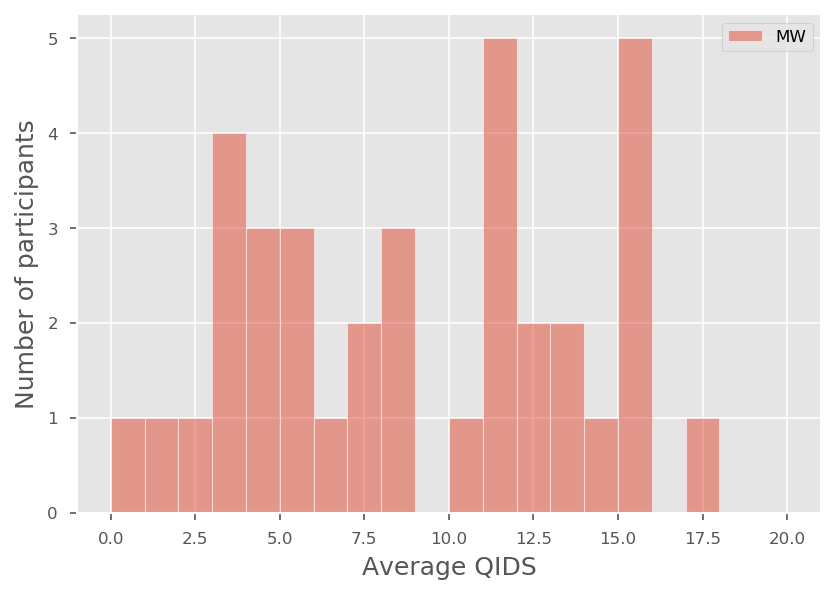

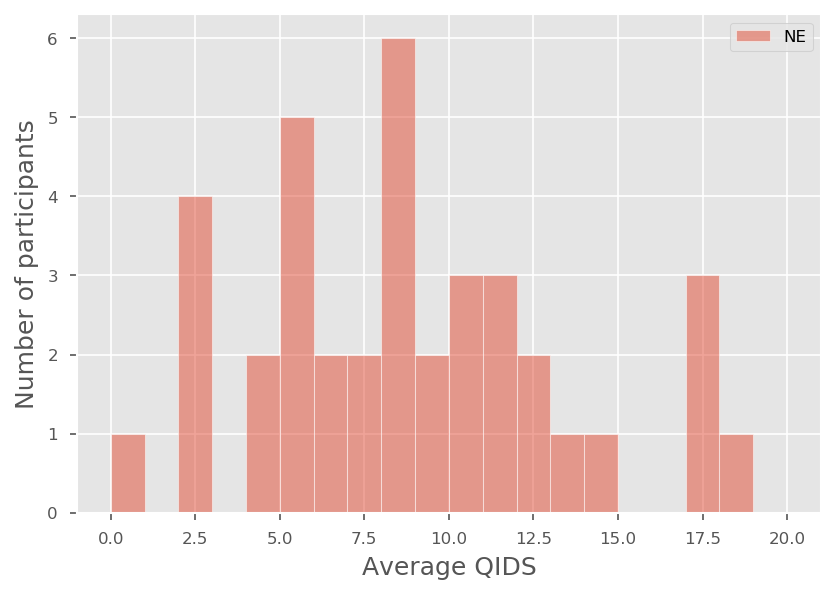

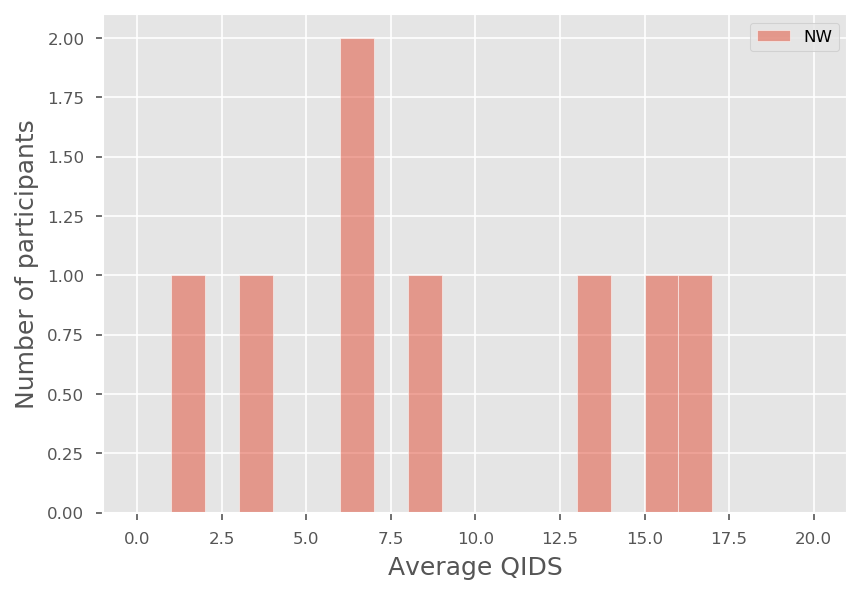

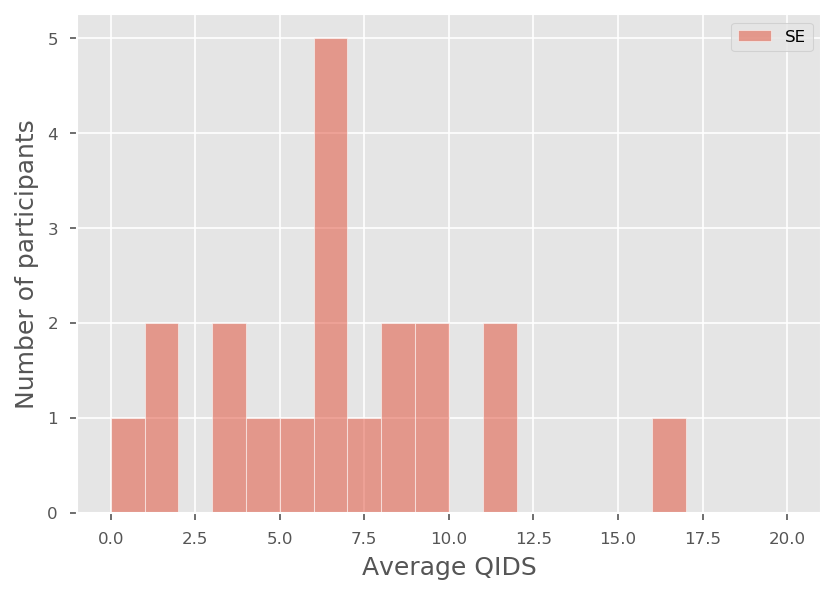

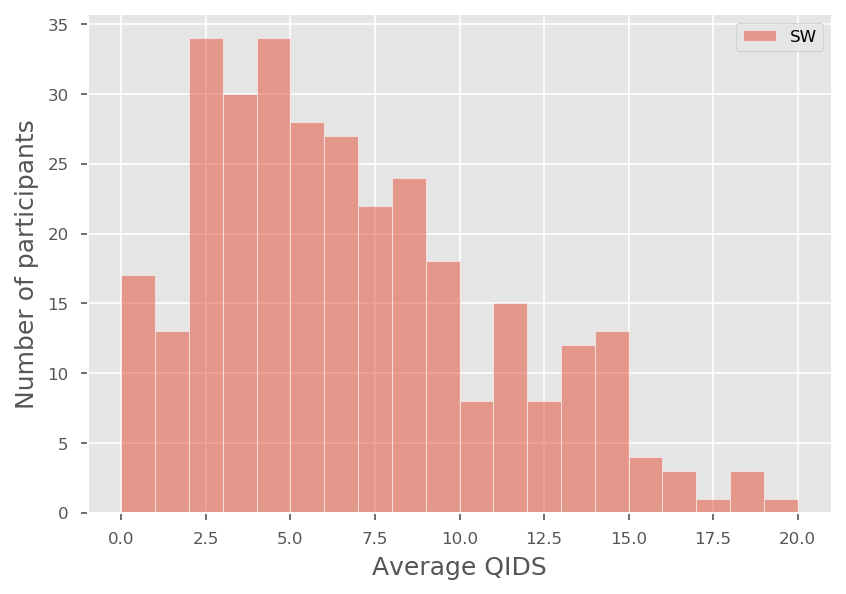

In [61]:
    # Histogram for each regions
    regions = ['MW', 'NE', 'NW', 'SE', 'SW']
    bins = np.arange(0, 21)
    
    region_dict = pd.DataFrame.to_dict(concat_pd[['QIDS', 'Region']])
    
    qids_array = np.array(list(region_dict['QIDS'].values()))
    region_array = np.array(list(region_dict['Region'].values()))
    
    for region in regions:
        fig = plt.figure(dpi=150)
        plt.hist(qids_array[region_array==region], bins=bins, ec='white', alpha=0.5, label=region)
    
        plt.xlabel('Average QIDS')
        plt.ylabel('Number of participants')
        plt.legend()
        plt.show()

['A-1-0',
 'A-2-0',
 'A-2-1',
 'A-4-0',
 'A-5-0',
 'A-6-0',
 'B-1-0',
 'C-1-0',
 'D-1-0',
 'E-1-0',
 'G-2-0',
 'G-4-0',
 'H-1-0',
 'H-2-0',
 'H-3-0',
 'I-1-0',
 'I-2-0',
 'I-4-0',
 'J-2-0',
 'K-1-0',
 'K-2-0',
 'K-3-0',
 'M-1-0',
 'M-2-0',
 'M-3-0',
 'N-1-0',
 'N-2-0',
 'N-3-0',
 'P-1-0',
 'Q-1-0',
 'Q-2-0',
 'Q-3-0',
 'Q-5-0',
 'R-1-0',
 'R-2-0',
 'R-3-0',
 'S-1-0',
 'S-2-0',
 'S-3-0',
 'S-5-0',
 'S-6-0',
 'V-1-0',
 'X-2-0',
 'X-3-0']
1294


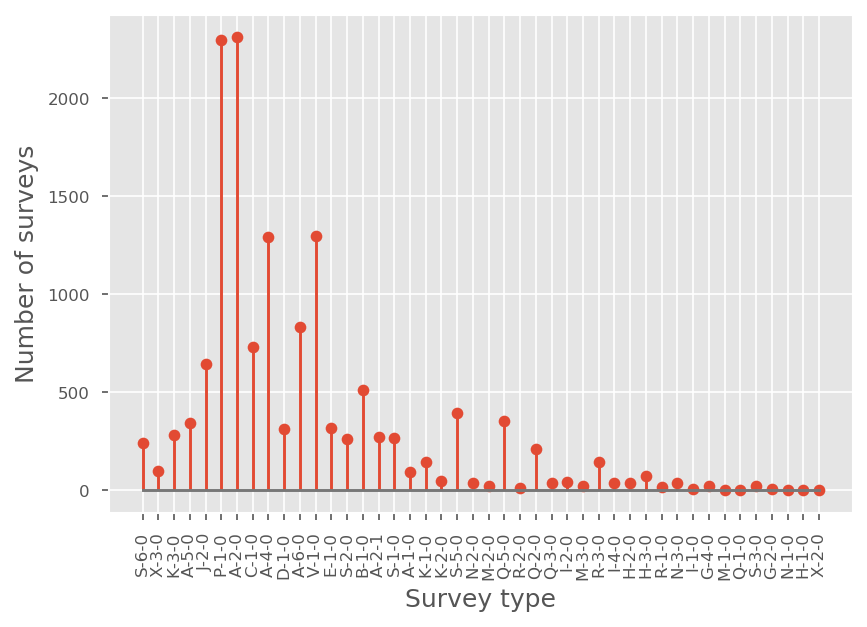

In [62]:
    # Can we plot histogram of survey ids?
    survey_counter = Counter(survey_ids)
    
    fig8 = plt.figure(8, dpi=150)
    plt.stem(survey_counter.values(), use_line_collection=True)
    plt.xticks(np.arange(len(survey_counter.values())), 
               labels=survey_counter.keys(),
               rotation='vertical')
    plt.xlabel('Survey type')
    plt.ylabel('Number of surveys')
    
    panels = list(survey_counter.keys())
    panels.sort()
    pprint.pprint(panels)
    
    panels = survey_counter
    #print(panels['I-1-0'], panels['I-2-0'], panels['M-1-0'], panels['M-2-0'], panels['M-3-0'])
    pprint.pprint(panels['A-4-0'])
    

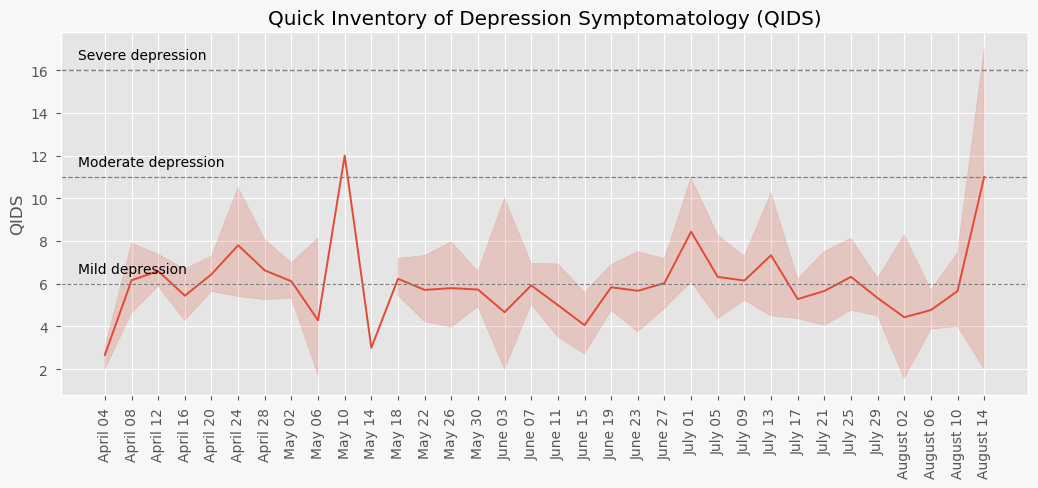

In [80]:
    # Delta qids as a function of time
    qids_ids = [key for key in participant_dict if \
                len(participant_dict[key]['QIDS']) > 1 and \
                'state' in participant_dict[key] and \
                participant_dict[key]['state'] == 'Texas']# and\
                #participant_dict[key]['healthcare_worker'] == 'Yes']
    
    qids_dict = {key:participant_dict[key] for key in qids_ids}
    
    epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
    epoch2 = int(datetime.date.today().strftime('%s'))
    
    ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))
    
    d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%m %d')
    d2s2 = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')
    
    data_dict = {'delta_qids': [],
                 'qids': [],
                 'nresponses': [],
                 'timestamp': [],
                 'timestring': [],
                 'timestring2': [],
                 'gender': []}
    
    const = 60*60*24*4
    
    for key in qids_dict:
        qids = qids_dict[key]['QIDS']
        
        values = np.array(list(qids.values()))
        #values = values + 0.5*np.random.rand(values.size) - 0.25
        timestamps = np.array(list(qids.keys()))
        indices = np.argsort(timestamps)[::-1]
        
        for idx in range(indices.size-1):
            #time_stamp = datetime.datetime.fromtimestamp((const*timestamps[indices[idx]]//(const*1000)))
            time_stamp = const*(timestamps[indices[idx]]//(const*1000))
            data_dict['timestamp'].append(time_stamp)
            data_dict['nresponses'].append(1)
            data_dict['qids'].append(values[indices[idx]])
            data_dict['timestring'].append(d2s(time_stamp*1000))
            data_dict['timestring2'].append(d2s2(time_stamp*1000))
            data_dict['gender'].append(qids_dict[key]['gender'])
            
            delta_qids = values[indices[idx]] - values[indices[idx+1]]
            data_dict['delta_qids'].append(delta_qids)
    
    data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')
    
    timestamps = np.unique(np.array(data_dict['timestamp']))
    labels = [d2s2(timestamp*1000) for timestamp in timestamps]
    
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(9.6*1.3, 4.8), dpi=100)
    fig.patch.set_facecolor(bg_color)
    
    #handle = sns.boxplot(x='timestring', y='qids',
    #                     data=data_pd, hue='gender')
    handle = sns.lineplot(x='timestring', y='qids', data=data_pd)
    
    handle.set_ylabel('QIDS')
    handle.set_xlabel('')
    plt.title('Quick Inventory of Depression Symptomatology (QIDS)')
    #plt.xticks(xticks, labels=labels, rotation='vertical')
    plt.xticks(np.arange(len(labels)), labels=labels, rotation='vertical', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add horizontal lines differentiating into various zones
    plt.axhline(y=6.0, linestyle='--', color='gray', linewidth=0.8)
    plt.annotate('Mild depression', xy=(-1, 6.5))
    
    plt.axhline(y=11.0, linestyle='--', color='gray', linewidth=0.9)
    plt.annotate('Moderate depression', xy=(-1, 11.5))
    
    plt.axhline(y=16.0, linestyle='--', color='gray', linewidth=1.0)
    plt.annotate('Severe depression', xy=(-1, 16.5))
    
    plt.show()
    
    

Text(0, 0.5, 'QIDS')

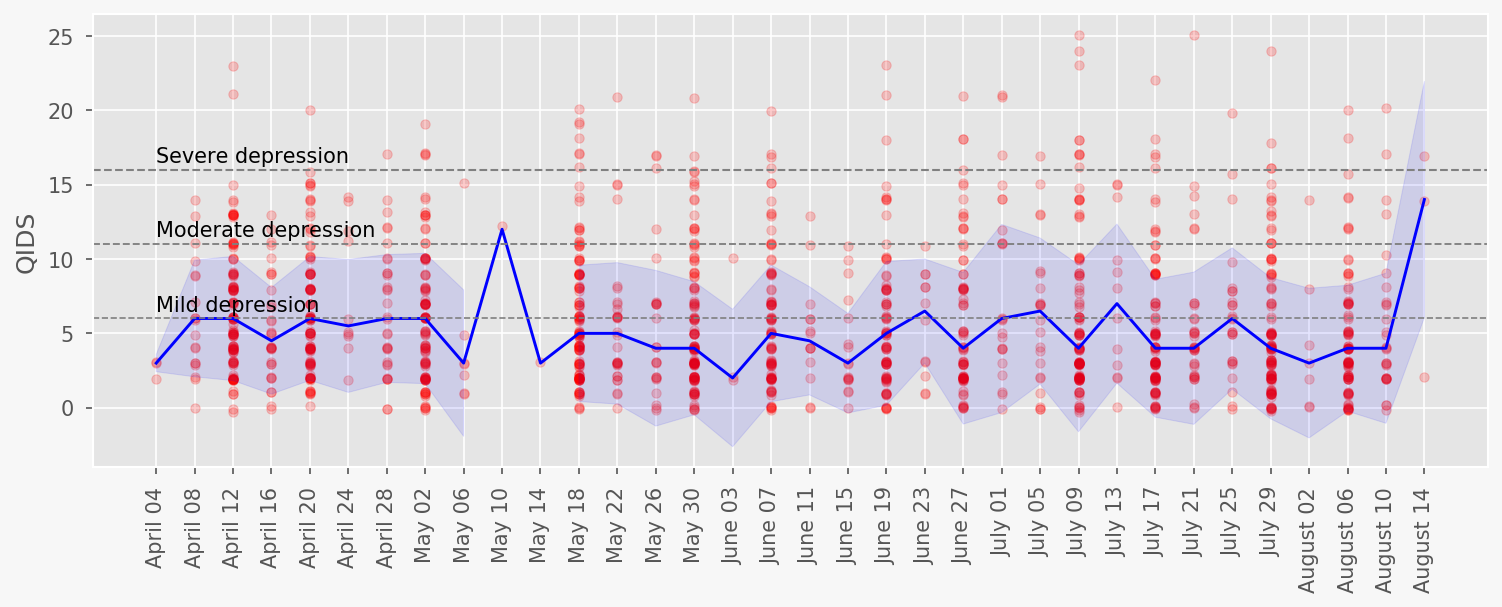

In [82]:
    # QIDS averaging a la Ashok
    winsize = 21
    
    data_pd_dict = pd.DataFrame.to_dict(data_pd[['qids', 'timestamp', 'nresponses']])
    #qids_array = np.array(list(data_pd_dict['qids'].values()))
    timestamp_array = np.array(list(data_pd_dict['timestamp'].values()))
    #nresponses_array = np.array(list(data_pd_dict['nresponses'].values()))
    
    timestamps = np.unique(timestamp_array)
    data_pd_agg = data_pd[['qids', 'timestamp', 'nresponses']].groupby(by='timestamp').agg({'qids': 'median', 'nresponses': 'sum'})
    data_pd_std = data_pd[['qids', 'timestamp', 'nresponses']].groupby(by='timestamp').agg({'qids': 'std'})
    qids_array = np.array(list(pd.DataFrame.to_dict(data_pd_agg)['qids'].values()))
    qids_std_array = np.array(list(pd.DataFrame.to_dict(data_pd_std)['qids'].values()))
    nresponses_array = np.array(list(pd.DataFrame.to_dict(data_pd_agg)['nresponses'].values()))
    
    # Moving average the data
    #qids_array = np.convolve(qids_array, np.ones(winsize)/winsize, 'same')
    #timestamp_array = np.convolve(timestamp_array, np.ones(winsize)/winsize, 'valid')
    
    fig, ax = plt.subplots(dpi=150, figsize=[12, 4])
    fig.patch.set_facecolor(bg_color)
    qids_vals = np.array(list(data_pd_dict['qids'].values())) + np.random.randn(len(timestamp_array))/10
    ax.scatter(timestamp_array, qids_vals, marker='o', 
                edgecolors='r', facecolors='r', alpha=0.2, s=20)
    ax.plot(timestamps, qids_array, 'b-')
    
    ax.fill_between(timestamps, qids_array - qids_std_array, qids_array + qids_std_array, alpha=0.1, color='b')
    #ax.plot(timestamps, qids_array + qids_std_array, 'b--', linewidth=1.0)
    #ax.plot(timestamps, qids_array - qids_std_array, 'b--', linewidth=1.0)
    _ = plt.xticks(timestamps, labels=[d2s2(x*1000) for x in timestamps], rotation='vertical', fontsize=10)
    _ = plt.yticks(fontsize=10)
    
    # Add horizontal lines differentiating into various zones
    plt.axhline(y=6.0, linestyle='--', color='gray', linewidth=0.8)
    plt.annotate('Mild depression', xy=(timestamps[0], 6.5))
    
    plt.axhline(y=11.0, linestyle='--', color='gray', linewidth=0.9)
    plt.annotate('Moderate depression', xy=(timestamps[0], 11.5))
    
    plt.axhline(y=16.0, linestyle='--', color='gray', linewidth=1.0)
    plt.annotate('Severe depression', xy=(timestamps[0], 16.5))
    
    plt.ylabel('QIDS')
    #plt.plot(timestamp_array, qids_array)

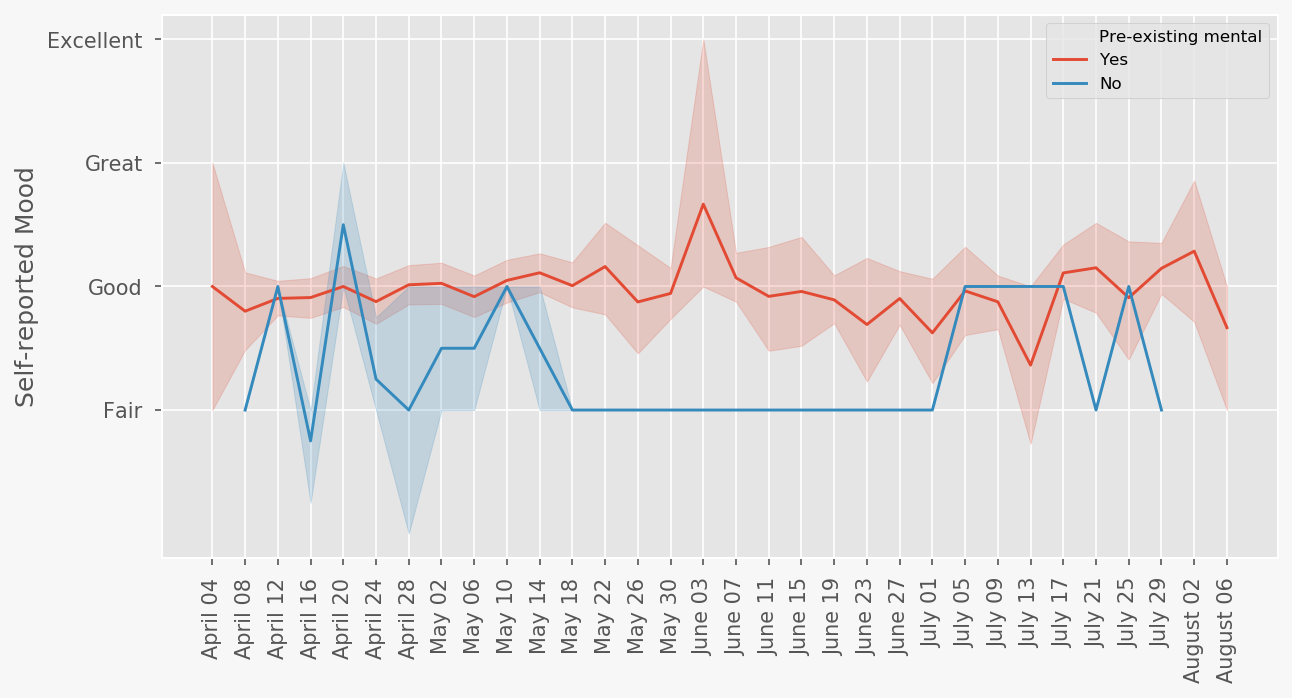

In [66]:
    # Extract mood IDs
    mood_ids = [key for key in participant_dict \
                if len(participant_dict[key]['A']) > 1 and\
                'state' in participant_dict[key] and\
                participant_dict[key]['state'] == 'Texas' and
                participant_dict[key]['gender'] in ['male', 'female']]
    mood_db = {key:participant_dict[key] for key in mood_ids}
    
    data_dict = {'mood': [],
                 'nresponses': [],
                 'timestamp': [],
                 'timestring': [],
                 'timestring2': [],
                 'gender': [],
                 'healthcare worker': [],
                 'Pre-existing mental': [],
                 'Pre-existing physical': []}
    
    mood_dict = {'terrible': 0,
                 'poor': 1,
                 'fair': 2,
                 'good': 3,
                 'great': 4,
                 'excellent': 5}
    
    const = 60*60*24*4*1000
    
    for key in mood_db:
        A_list = mood_db[key]['A']
        
        mood_values = [A['mood'] for A in A_list]
        timestamps = [A['time'] for A in A_list]
        
        timestamps = [const*(int(timestamp//const)) for timestamp in timestamps]
        
        data_dict['mood'] += [mood_dict[mood] for mood in mood_values]
        data_dict['timestamp'] += timestamps
        data_dict['timestring'] += [d2s(timestamp) for timestamp in timestamps]
        data_dict['timestring2'] += [d2s2(timestamp) for timestamp in timestamps]
        data_dict['gender'] += [mood_db[key]['gender'].capitalize() for idx in range(len(timestamps))]
        data_dict['nresponses'] += [1 for idx in range(len(timestamps))]
        data_dict['healthcare worker'] += [mood_db[key]['healthcare_worker'] for idx in range(len(timestamps))]
        
        if len(mood_db[key]['pre_mental']) > 0:
            pre_mental = 'Yes'
        else:
            pre_mental = 'No'
            
        if len(mood_db[key]['pre_physical']) > 0:
            pre_physical = 'Yes'
        else:
            pre_physical = 'No'
        
        data_dict['Pre-existing mental'] += [pre_mental for idx in range(len(timestamps))]
        data_dict['Pre-existing physical'] += [pre_physical for idx in range(len(timestamps))]
    
    data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')
    
    timestamps = np.unique(np.array(data_dict['timestamp']))
    labels = [d2s2(timestamp) for timestamp in timestamps]
    
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(9.6, 4.8), dpi=150)
    fig.patch.set_facecolor(bg_color)

    handle = sns.lineplot(x='timestring', y='mood', hue='Pre-existing mental', data=data_pd)
    
    handle.set_ylabel('Self-reported Mood')
    handle.set_xlabel('')
    
    y_labels = [label.capitalize() for label in list(mood_dict.keys())]
    
    plt.xticks(np.arange(len(labels)), labels=labels, rotation='vertical', fontsize=10)
    plt.yticks(list(mood_dict.values())[2:], labels=y_labels[2:], fontsize=10)
    
    plt.show()


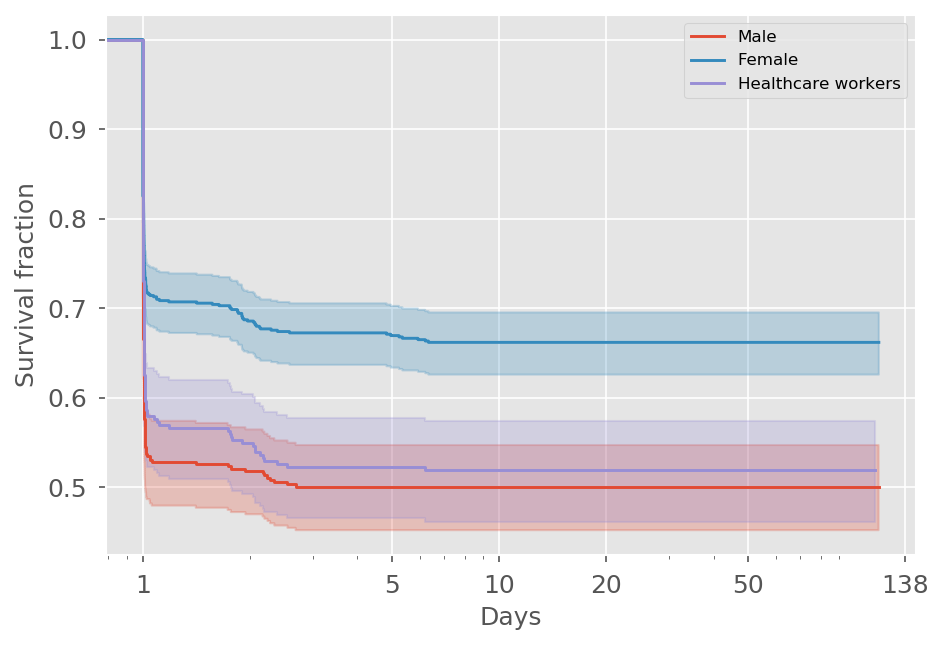

In [76]:
    # Attrition curve
    attrition_thres = 0.05
    
    epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
    epoch2 = int(datetime.date.today().strftime('%s'))
    
    ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))
    
    nparticipants = len(participant_dict)
    
    response_image = np.ones((nparticipants, ntimes, 3))
    start_day = np.zeros(nparticipants)
    duration = np.zeros(nparticipants)
    genders = np.zeros(nparticipants)
    healthcare = np.zeros(nparticipants)
    
    for idx, key in enumerate(participant_dict):
        participant = participant_dict[key]
        panels = participant['panels']
        timestamps = participant['timestamps']
        if participant['gender'] == 'male':
            genders[idx] = 1
        elif participant['gender'] == 'female':
            genders[idx] = 2
        
        if participant['healthcare_worker'] == 'Yes':
            healthcare[idx] = 1
        
        mintime = min(timestamps)
        maxtime = max(timestamps)
        
        start_day[idx] = (mintime/1000 - epoch1)/(60*60*24)
        duration[idx] = (maxtime-mintime)/(1000*60*60*24) + 1
        
        for timestamp in timestamps:
            delta = int(np.floor((timestamp/1000 - epoch1)/(60*60*24))) - 1
            response_image[idx, delta, 1:] = 0
    
    #variances = np.var(response_image[:, :, 1], axis=1)
    variances = duration/(ntimes-start_day)
    indices = np.argsort(variances)
    
    # Do a KaplanMeierFitter
    observed = (duration/(ntimes - start_day) < attrition_thres)
    
    kmf_male = KaplanMeierFitter()
    kmf_female = KaplanMeierFitter()
    kmf_healthcare = KaplanMeierFitter()
    
    kmf_male.fit(duration[genders==1], event_observed=observed[genders==1])
    kmf_female.fit(duration[genders==2], event_observed=observed[genders==2])
    kmf_healthcare.fit(duration[healthcare==1], event_observed=observed[healthcare==1])
    
    fig = plt.figure(dpi=150)
    kmf_male.plot(label='Male')
    kmf_female.plot(label='Female')
    kmf_healthcare.plot(label='Healthcare workers')
    plt.xscale('log')
    plt.xticks([1, 5, 10, 20, 50, ntimes], labels=['1', '5', '10', '20', '50', str(ntimes)], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Survival fraction', fontsize=12)
    plt.tight_layout()
    plt.show()
    

['United States' 'United Kingdom' 'India' 'South Africa' 'Brazil' 'Mexico']


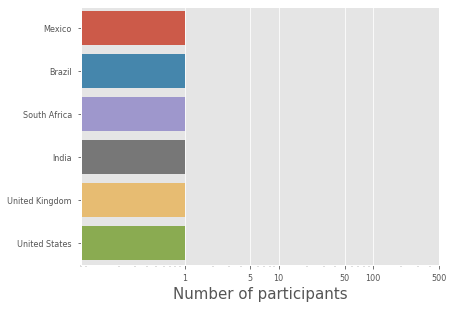

In [83]:
    # Countries verification
    for idx, name in enumerate(countries):
        country = pycountry.countries.search_fuzzy(name)[0]
        countries[idx] = country.name
    
    countries_counter = Counter(countries)
        
    counts = np.array(list(countries_counter.values()))
    indices = np.argsort(counts)[::-1]
    names = np.array(list(countries_counter.keys()))
    
    handle = sns.barplot(counts[indices], names[indices])
    handle.set_xlabel('Number of participants', fontsize=15)
    plt.xscale('log')
    plt.xticks([1, 5, 10, 50, 100, 500], labels=['1', '5', '10', '50', '100', '500'])
    plt.tight_layout()
    
    print(names)
    #print(d_resp)
    #phone_info = phonenumbers.parse('+14126419235')
    #ph_geocoder.country_name_for_number(phone_info, 'en')    
       

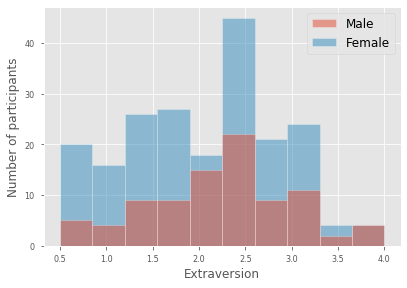

In [195]:
    # IPIP analysis
    ipip_scores = np.array(utils.getall(participant_dict, 'IPIP'))
    names = ['Extraversion', 'Agreeableness', 'Conscientiousness',
             'Neuroticism', 'Imagination']
    
    genders = []
    ipip_scores = []
    for key in participant_dict:
        participant = participant_dict[key]
        if 'IPIP' in participant.keys():
            genders.append(participant['gender'])
            ipip_scores.append(participant['IPIP'])
    
    ipip_scores = np.array(ipip_scores)
    genders = np.array(genders)
        
    idx=0
    n, bins, patches = plt.hist(ipip_scores[genders=='male', idx], alpha=0.5,
                                ec='white', label='Male', bins=10, zorder=2)
    plt.hist(ipip_scores[genders=='female', idx], alpha=0.5,
                         ec='white', label='Female', bins=bins, zorder=1)
    plt.xlabel(names[idx])
    plt.ylabel('Number of participants')
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
    # Rudimentary time analysis
    # Create an image with responses as a function of time
    epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
    epoch2 = int(datetime.date.today().strftime('%s'))
    
    ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))
    
    time_array = np.arange(ntimes)
    covid_house_recovering = np.zeros(ntimes)
    covid_house_recovered = np.zeros(ntimes)
    
    for key in participant_dict:
        P_array = participant_dict[key]['P']
        
        for P_dict in P_array:
            timestamp = P_dict['time']
            day = int((timestamp/1000 - epoch1)/(60*60*24)) - 1
            
            if 'has fully recovered' in P_dict['covid_house']:
                covid_house_recovered[day] += 1
            elif 'is recovering' in P_dict['covid_house']:
                covid_house_recovering[day] += 1
                
    
    plt.plot(time_array[covid_house_recovered > 0],
             covid_house_recovered[covid_house_recovered > 0],
             label='Recovered')
    plt.plot(time_array[covid_house_recovering > 0],
             covid_house_recovering[covid_house_recovering > 0],
             label='Recovering')
    plt.legend(fontsize=12)
    plt.xlabel('Days elapsed since April 4th')
    plt.ylabel('Number of responses')
    
    ticks = [datetime.datetime.fromtimestamp(epoch1 + d*24*60*60).strftime('%B %d') for \
             d in range(0, ntimes, 10)]
    plt.xticks(range(0, ntimes, 10), labels=ticks)
    
    plt.show()

In [ ]:
    # Time analysis for normalcy
    epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
    epoch2 = int(datetime.date.today().strftime('%s'))
    
    ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))
    
    time_array = np.arange(ntimes)
    normal_array_india = np.zeros(ntimes)
    normal_array_usa = np.zeros(ntimes)
    normal_array_lebanon = np.zeros(ntimes)
    
    nresponses = np.zeros(ntimes)
    
    for key in participant_dict:
        V_array = participant_dict[key]['V']
        country = participant_dict[key]['country']
        
        for V_dict in V_array:
            timestamp = V_dict['time']
            day = int((timestamp/1000 - epoch1)/(60*60*24)) - 1
            
            nresponses[day] += 1
            
            if 'Yes' == V_dict['situation_normal']:
                if country == 'US':
                    normal_array_usa[day] += 1                
                elif country == 'IN':
                    normal_array_india[day] += 1
                elif country == 'LB':
                    normal_array_lebanon[day] += 1
    if False:
        plt.plot(time_array[normal_array_usa > 0],
                 normal_array_usa[normal_array_usa > 0],
                 label='United States')
        plt.plot(time_array[normal_array_lebanon > 0],
                 normal_array_lebanon[normal_array_lebanon > 0],
                 label='Lebanon')
        plt.plot(time_array[normal_array_india > 0],
                 normal_array_india[normal_array_india > 0],
                 label='India')

    normal_array = normal_array_usa + normal_array_lebanon + normal_array_india
    plt.plot(time_array[normal_array > 0],
             normal_array[normal_array > 0],
             label='Number reporting normalcy')
    #plt.plot(time_array[normal_array > 0],
    #         nresponses[normal_array > 0],
    #         label='Number of responses')
    plt.ylabel('Number of responses')
    
    #plt.legend(fontsize=10)
    ticks = [datetime.datetime.fromtimestamp(epoch1 + d*24*60*60).strftime('%B %d') for \
             d in range(0, ntimes, 10)]
    plt.xticks(range(0, ntimes, 10), labels=ticks)
    
    plt.show()

In [ ]:
    # Time to process panel A
    
    # Mood dictionary
    mood_dict = {'terrible': 0,
                 'poor': 1,
                 'fair': 2,
                 'good': 3,
                 'great': 4,
                 'excellent': 5}
    health_worry_dict = {
        'Very worried': 0,
        'Worried': 1,
        'Cautious': 2,
        'Not at all': 3
    }
    epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
    epoch2 = int(datetime.date.today().strftime('%s'))
    
    ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))
    
    time_array = np.arange(ntimes)
    mood_array = np.zeros((4, ntimes))
    
    for key in participant_dict:
        A_array = participant_dict[key]['A']
        country = participant_dict[key]['country']
        
        for A_dict in A_array:
            timestamp = A_dict['time']
            day = int((timestamp/1000 - epoch1)/(60*60*24)) - 1
            
            if country == 'US':
                mood_array[health_worry_dict[A_dict['health_worry']], day] += 1
            
    plt.plot(time_array, mood_array.T)
    plt.show()
            
            

[123, 131, 641, 641, 242, 241, 6, 45, 45, 80, 107, 21, 1, 13, 3, 2, 4, 4, 3, 1] ['Z', 'A', 'U', 'S', 'I', 'N', 'E', 'M', 'X', 'G', 'B', 'L', 'F', 'R', 'T', 'H', 'P', 'C', 'D', 'Q']


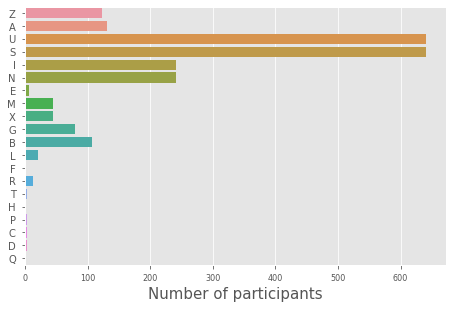

In [84]:
    # Some more distributions
    marriages = [participant_dict[key]['country'] for key in participant_dict]
    
    marriage_counter = dict()
    
    for marriage in marriages:
        if len(marriage) > 0:
            if marriage == 'NA':
                continue
            for token in marriage:
                if token in marriage_counter.keys():
                    marriage_counter[token] += 1
                else:
                    marriage_counter[token] = 1
            
    
    #marriage_counter = Counter(marriages)
    
    x = list(marriage_counter.values())
    y = list(marriage_counter.keys())
    
    #handle = sns.barplot([x[0], x[1], x[2], x[3], x[4], x[5]],
    #                     [y[0], y[1], y[2], y[3], y[4], y[5]])
    handle = sns.barplot(x, y)
    handle.set_xlabel('Number of participants', fontsize=15)
    plt.yticks(fontsize=10)
    #plt.xscale('log')
    #plt.xticks([1, 5, 10, 50, 100, 200], labels=['1', '5', '10', '50', '100', '200'])
    plt.tight_layout()
    
    print(x, y)

In [196]:
    # Average QIDS per country
    qids_array = [list(participant_dict[key]['QIDS'].values())[0] for key in participant_dict if 'QIDS' in participant_dict[key]]
    country_array = [participant_dict[key]['country'] for key in participant_dict if 'QIDS' in participant_dict[key]]
    
    qids_array = np.array(qids_array)
    country_array = np.array(country_array)
    
    qids_usa = qids_array[country_array == 'US'].mean()
    qids_india = qids_array[country_array == 'IN'].mean()
    qids_lebanon = qids_array[country_array == 'LB'].mean()
    
    print(qids_usa, qids_lebanon, qids_india)

IndexError: list index out of range

In [ ]:
    # Analyze panels I
    I_list = utils.cat_arrays(participant_dict, 'M')
    
    sick_array = [I['sick_days'] for I in I_list]
    hospital_array = [I['hospitalized'] for I in I_list]
    oxygen_array = [I['oxygen_days'] for I in I_list]
    intubation_array = [I['intubation_days'] for I in I_list]
    icu_array = [I['icu_days'] for I in I_list]
    worse_array = [I['worse_days'] for I in I_list]
    time_array = [I['time'] for I in I_list]
    
    keys = ['cough', 'temperature', 'nose', 'breathing', 'pain', 'nausea', 'worry_dying', 'testing', 'remnants']
    #keys = ['sick_days', 'hospitalized', 'oxygen_days', 'intubation_days', 'icu_days', 'worse_days']
    keys = keys + ['gender', 'burned', 'sleep', 'stress', 'social_distancing', 'own_room', 'quarantine']
    #keys = ['age', 'gender']
    
    titles = ['Severity of cough', 'Body temperature', 'Severity of running nose', 'Breathing problem',
              'Severity of body pains', 'Severity of nausea', 'Are you worried about dying', 'Access to testing',
              'Remnant effects of the disease']
    #titles = ['Number of sick days', 'Number of days in hospital', 'Number of days on oxygen', 
    #          'Number of days on intubation', 'Number of days in ICU', 'Number of days worse than Flu']
    #titles = ['Gender']
    titles = titles + ['Gender', 'I feel more burned out than before', 'My sleep has been disrupted',
                      'Stress levels', 'Attempts to maintain social distance', 'Patient has own room?',
                      'Patient is quarantined?']
    temperature_dict = {'below 101 Fahrenheit (38.3 Celsius)': 'Below 101 F',
                        'I did not have fever': 'No fever',
                        '103-105 Fahrenheit (39.4 - 40.5 Celsius)': '103-105 F',
                        '101-103 Fahrenheit (38.3 - 39.4 Celsius)': '101-103 F',
                        '101-103 Fahrenheit': '101-103 F',
                        'below 101 Fahrenheit': 'Below 101 F',
                        '103-105 Fahrenheit': '103-105 F'}
    
    temperature_dict = {'I did not have fever': 'No fever',
         '101-103 Fahrenheit (38.3 - 39.4 Celsius)': '101-103 F',
         'below 101 Fahrenheit (38.3 Celsius)': 'Below 101 F',
         'greater than 105 Fahrenheit (40.5 Celsius)': 'Greater than 105 F',
         '101-103 Fahrenheit': '101-103 F',
         'below 101 Fahrenheit': 'Below 101 F',
         '103-105 Fahrenheit (39.4 - 40.5 Celsius)': '103-105 F'}
    
    for idx, key in enumerate(keys):
        if 'remnants' in key:
            vals_array = [item for I in I_list for item in I[key]]
        else:
            vals_array = [I[key] for I in I_list]
        
        if key == 'temperature':
            vals_array = [temperature_dict[val] for val in vals_array]
        
        fig = plt.figure(idx, dpi=150)
        vals_counter = Counter(vals_array)
        
        #if key == 'temperature':
        #    pprint.pprint(vals_counter)
        
        try:
            del vals_counter['other-check']
        except KeyError:
            pass
        
        x = np.array(list(vals_counter.values()))
        y = np.array(list(vals_counter.keys()))
        indices = np.argsort(x)[::-1]
        
        handle = sns.barplot(x[indices], y[indices])
        #n, bins, patches = plt.hist(vals_array, ec='white', alpha=0.5)
        #plt.xlabel('Recovered data (approx.)')
        plt.title(titles[idx])
        #plt.xlabel(titles[idx])
        plt.yticks(fontsize=12)
        #plt.xticks(np.arange(0, 20, 2))
        plt.ylabel('Number of participants')

        #labels = [datetime.datetime.fromtimestamp(bi/1000).strftime('%B %d') for bi in bins]
        #plt.xticks(bins, labels=labels, rotation='vertical')
        plt.tight_layout()
    plt.show()
    
    

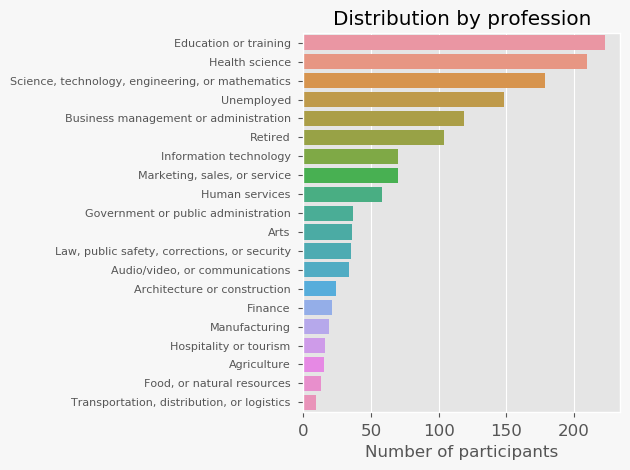

In [85]:
    # Analyze professions
    
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    fig.patch.set_facecolor(bg_color)
    pro_counter = {"agriculture": 0,
                    "food, or natural resources": 0,
                    "architecture or construction": 0,
                    "arts": 0,
                    "audio/video, or communications": 0,
                    "business management or administration": 0,
                    "education or training": 0,
                    "finance": 0,
                    "government or public administration": 0,
                    "health science": 0,
                    "hospitality or tourism": 0,
                    "human services": 0,
                    "information technology": 0,
                    "law, public safety, corrections, or security": 0,
                    "manufacturing": 0,
                    "marketing, sales, or service": 0,
                    "science, technology, engineering, or mathematics": 0,
                    "transportation, distribution, or logistics": 0,
                    "unemployed": 0,
                    "retired": 0}
    professions = utils.cat_arrays(participant_dict, 'jobs')
    
    for profession in professions:
        try:
            pro_counter[profession] += 1
        except KeyError:
            continue
    
    values = np.array(list(pro_counter.values()))
    names = np.array([key.capitalize() for key in pro_counter.keys()])
    indices = np.argsort(values)[::-1]
    
    handle = sns.barplot(values[indices], names[indices])
    plt.xlabel('Number of participants', fontsize=12)
    plt.title('Distribution by profession')
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('results/profession_distribution.png', dpi=100)
    
    

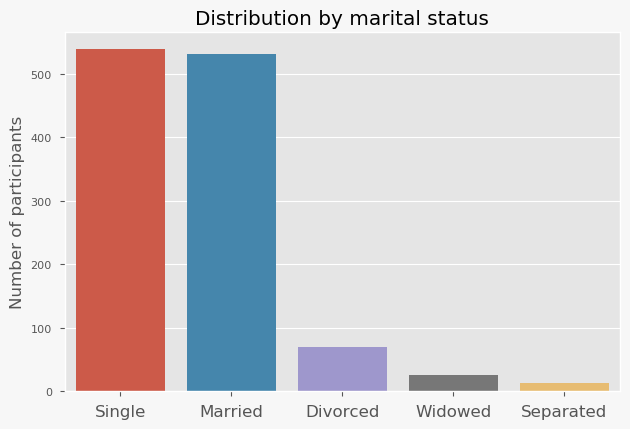

In [86]:
    # Marital status
    marital_status = utils.getall(participant_dict, 'marital_status')
    children_0_3 = utils.getall(participant_dict, 'children_0_3')
    children_4_12 = utils.getall(participant_dict, 'children_4_12')
    children_13_18 = utils.getall(participant_dict, 'children_13_18')
   
    married_counter = Counter(marital_status)
    del married_counter['NA']
    
    names = np.array([key.capitalize() for key in married_counter])
    values = np.array([married_counter[key] for key in married_counter])
    indices = np.argsort(values)[::-1]
    
    fig = plt.figure(dpi=100)
    fig.patch.set_facecolor(bg_color)
    handle = sns.barplot(names[indices], values[indices])
    plt.ylabel('Number of participants', fontsize=12)
    plt.title('Distribution by marital status')
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('results/profession_distribution.png', dpi=100)

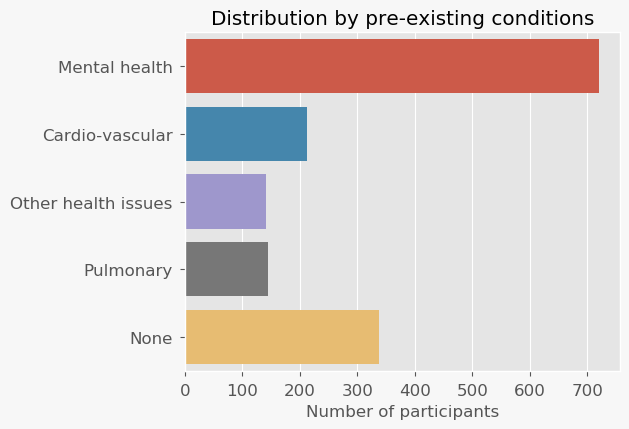

In [88]:
    # Preexisting conditions
    pre_physical = utils.cat_arrays(participant_dict, 'pre_physical')
    pre_mental = utils.cat_arrays(participant_dict, 'pre_mental')
    
    conversion_dict = {
        'None': ['none of the above', 'None'],
        'Mental health': ['depression', 'anxiety disorder',
                   'other serious mental health issues',
                   'obsessive compulsive disorder',
                   'addiction (drug, alcohol)',
                   'bipolar'],
        'Cardio-vascular': ['abnormal blood pressure',
                            'diabetes'],
        'Pulmonary': ['asthma', 'asthma, COPD or other lung disease'],
        'Other health issues': ['cancer', 'other serious health issues'] 
    }
    total_counter = {key:0 for key in conversion_dict}
    
    for idx in range(len(pre_physical)):
        physical = pre_physical[idx]
        mental = pre_mental[idx]
        
        for key in conversion_dict:
            if key == 'None':
                if physical in conversion_dict['None'] and mental in conversion_dict['None']:
                    total_counter['None'] += 1
            else:
                if physical in conversion_dict[key]:
                    total_counter[key] += 1
                if mental in conversion_dict[key]:
                    total_counter[key] += 1
    
    names = np.array([key.capitalize() for key in total_counter])
    values = np.array([total_counter[key] for key in total_counter])
    #indices = np.argsort(values)[::-1]
    indices = [1, 2, 4, 3, 0]
    
    fig = plt.figure(dpi=100)
    fig.patch.set_facecolor(bg_color)
    handle = sns.barplot(values[indices], names[indices])
    plt.xlabel('Number of participants', fontsize=12)
    plt.title('Distribution by pre-existing conditions')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('results/profession_distribution.png', dpi=100)

In [ ]:
    utils = importlib.reload(utils)
    
    # Correlation with pre existing conditions?
    disease = 'abnormal blood pressure'
    healthy = 'none of the above'
    metric = 'situation'
    
    all_disease = utils.cat_arrays(participant_dict, 'pre_physical')
    
    disease_ids = [key for key in participant_dict if healthy not in participant_dict[key]['pre_physical']]
    healthy_ids = [key for key in participant_dict if healthy in participant_dict[key]['pre_physical']]
    
    disease_qids = [participant_dict[key]['QIDS'] for key in disease_ids if len(participant_dict[key]['QIDS']) > 0]
    healthy_qids = [participant_dict[key]['QIDS'] for key in healthy_ids if len(participant_dict[key]['QIDS']) > 0]
    
    disease_A = [participant_dict[key]['A'][-1][metric] for key in disease_ids \
                 if len(participant_dict[key]['A']) > 0]
    healthy_A = [participant_dict[key]['A'][-1][metric] for key in healthy_ids \
                 if len(participant_dict[key]['A']) > 0]
    
    disease_qids_latest = [list(f.values())[0] for f in disease_qids]
    healthy_qids_latest = [list(f.values())[0] for f in healthy_qids]
    
    fig = plt.figure(figsize=(6.4, 4.8))
    n, bins, patches = plt.hist(disease_qids_latest, bins=10, ec='white',
                                alpha=0.5, label='With %s'%disease, zorder=2, density=True)
    n, bins, patches = plt.hist(healthy_qids_latest, bins=10, ec='white',
                                alpha=0.5, label='No pre-existing cond.', zorder=1, density=True)
    plt.xlabel('QIDS', fontsize=12)
    plt.ylabel('% participants', fontsize=12)
    plt.legend(fontsize=10)
    plt.yticks(np.arange(0, 0.16, 0.02), ['%d'%(100*t) for t in np.arange(0, 0.15, 0.02)], fontsize=12)
    plt.xticks(fontsize=12)
    
    plt.show()
    
    print('Disease: %.2f +/- %.2f'%(np.mean(disease_qids_latest), np.sqrt(np.var(disease_qids_latest))))
    print('Healthy: %.2f +/- %.2f'%(np.mean(healthy_qids_latest), np.sqrt(np.var(healthy_qids_latest))))
    
    print('Disease:')
    pprint.pprint(utils.Counter([item for sublist in disease_A for item in sublist]))
    
    print('Healthy:')
    pprint.pprint(utils.Counter([item for sublist in healthy_A for item in sublist]))

In [ ]:
    # Hypothesis testing!
    camsr_scores = [participant_dict[key]['CAMS-R'] for key in participant_dict\
                    if 'CAMS-R' in participant_dict[key]]
    genders =      [participant_dict[key]['gender'] for key in participant_dict\
                    if 'CAMS-R' in participant_dict[key]]
    
    camsr_scores = np.array(camsr_scores)
    genders = np.array(genders)
    
    camsr_male = camsr_scores[genders == 'male']
    camsr_female = camsr_scores[genders == 'female']
    
    mw_stat, mw_pval = stats.mannwhitneyu(camsr_male, camsr_female, alternative='greater')
    tt_stat, tt_pval = stats.ttest_ind(camsr_male, camsr_female, equal_var=False)
    
    print('Male: %.2f +/- %.2f'%(camsr_male.mean(), np.sqrt(camsr_male.var())))
    print('Feale: %.2f +/- %.2f'%(camsr_female.mean(), np.sqrt(camsr_female.var())))
    
    print('Mann-Whitney U: stat: %.2f; pval: %.2f'%(mw_stat, mw_pval))
    print('t-test: stat: %.2f; pval: %.2f'%(tt_stat, tt_pval))
    
    fig = plt.figure(dpi=150)
    n, bins, patches = plt.hist(camsr_male, bins=20, ec='white', alpha=0.5, label='Male', zorder=2)
    n, bins, patches = plt.hist(camsr_female, bins=bins, ec='white', alpha=0.5, label='Female', zorder=1)
    plt.legend()
    plt.xlabel('CAMS-R')
    plt.ylabel('Number of participants')
    plt.show()

In [ ]:
    # Responses by gender
    nresponses = [len(participant_dict[key]['timestamps']) for key in participant_dict]
    genders = [participant_dict[key]['gender'] for key in participant_dict]
    
    nresponses = np.array(nresponses)
    genders = np.array(genders)
    
    nresponses_male = nresponses[genders == 'male']
    nresponses_female = nresponses[genders == 'female']
    
    mw_stat, mw_pval = stats.mannwhitneyu(nresponses_male, nresponses_female, alternative='less')
    tt_stat, tt_pval = stats.ttest_ind(nresponses_male, nresponses_female, equal_var=False)
    
    print('Male: %.2f +/- %.2f'%(nresponses_male.mean(), np.sqrt(nresponses_male.var())))
    print('Female: %.2f +/- %.2f'%(nresponses_female.mean(), np.sqrt(nresponses_female.var())))
    
    print('Mann-Whitney U: stat: %.2f; pval: %.4f'%(mw_stat, mw_pval))
    print('t-test: stat: %.2f; pval: %.4f'%(tt_stat, tt_pval))
    
    fig = plt.figure(dpi=150)
    n, bins, patches = plt.hist(nresponses_male, bins=20, ec='white', alpha=0.5, label='Male', zorder=2)
    n, bins, patches = plt.hist(nresponses_female, bins=bins, ec='white', alpha=0.5, label='Female', zorder=1)
    plt.legend()
    plt.xlabel('Number of responses')
    plt.ylabel('Number of participants')
    plt.show()

In [ ]:
    # QIDS hypothesis testing
    qids_scores = [participant_dict[key]['QIDS'] for key in participant_dict\
                    if len(participant_dict[key]['QIDS']) > 0]
    genders =      [participant_dict[key]['gender'] for key in participant_dict\
                    if len(participant_dict[key]['QIDS']) > 0]
    
    qids_scores = np.array([list(qids.values())[0] for qids in qids_scores])
    genders = np.array(genders)
    
    qids_male = qids_scores[genders == 'male']
    qids_female = qids_scores[genders == 'female']
    
    mw_stat, mw_pval = stats.mannwhitneyu(qids_male, qids_female, alternative='less')
    tt_stat, tt_pval = stats.ttest_ind(qids_male, qids_female, equal_var=False)
    
    print('Male: %.2f +/- %.2f'%(qids_male.mean(), np.sqrt(qids_male.var())))
    print('Female: %.2f +/- %.2f'%(qids_female.mean(), np.sqrt(qids_female.var())))
    
    print('Mann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
    print('t-test: stat: %.2f; pval: %.4f'%(tt_stat, tt_pval))
    
    fig = plt.figure(dpi=150)
    n, bins, patches = plt.hist(qids_male, bins=20, ec='white', alpha=0.5, label='Male', zorder=2)
    n, bins, patches = plt.hist(qids_female, bins=bins, ec='white', alpha=0.5, label='Female', zorder=1)
    plt.legend()
    plt.xlabel('QIDS (lateset)')
    plt.ylabel('Number of participants')
    plt.show()

Counter({'None': 563, '1 to 4': 503, '5 to 10': 89, 'More than 10': 22})
Male: 0.49 +/- 0.66
Female: 0.71 +/- 0.71
Mann-Whitney U: stat: 129895.00; pval: 0.000000
t-test: stat: -5.43; pval: 0.0000


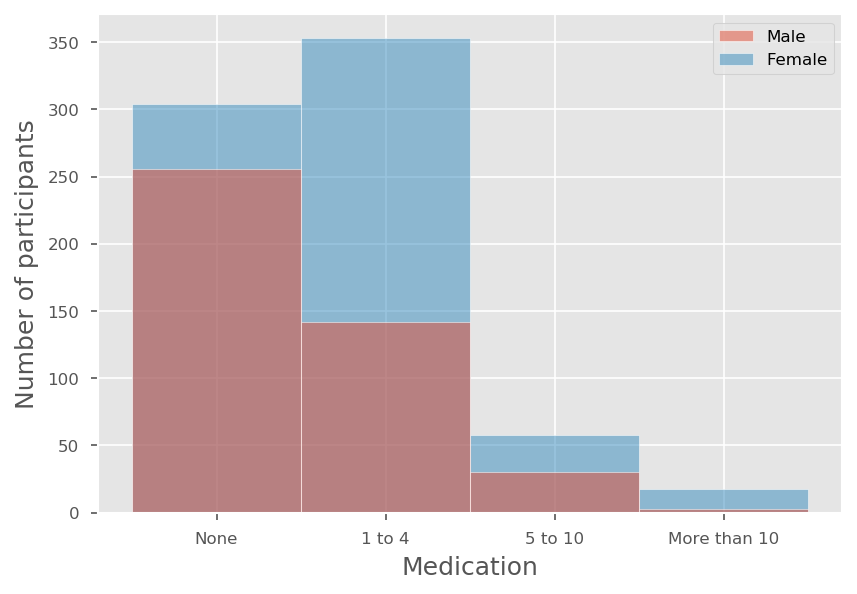

In [89]:
    # Substance/medication usage?
    medication = utils.getall(participant_dict, 'medications')
    genders = utils.getall(participant_dict, 'gender')
    
    medication_dict = {'None': 0,
                       '1 to 4': 1,
                       '5 to 10': 2,
                       'More than 10': 3,
                       'NA': 0,
                       'somewhat worried': 0,
                       'very worried': 0,
                       'not worried': 0}
    pprint.pprint(Counter(medication))
    medication_value = np.array([medication_dict[medic] for medic in medication])
    genders = np.array(genders)
    
    med_male = medication_value[genders == 'male']
    med_female = medication_value[genders == 'female']
    
    mw_stat, mw_pval = stats.mannwhitneyu(med_male, med_female, alternative='less')
    tt_stat, tt_pval = stats.ttest_ind(med_male, med_female, equal_var=False)
    
    print('Male: %.2f +/- %.2f'%(med_male.mean(), np.sqrt(med_male.var())))
    print('Female: %.2f +/- %.2f'%(med_female.mean(), np.sqrt(med_female.var())))
    
    print('Mann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
    print('t-test: stat: %.2f; pval: %.4f'%(tt_stat, tt_pval))
    
    fig = plt.figure(dpi=150)
    n, bins, patches = plt.hist(med_male, bins=np.arange(5), ec='white', alpha=0.5, label='Male', zorder=2)
    n, bins, patches = plt.hist(med_female, bins=bins, ec='white', alpha=0.5, label='Female', zorder=1)
    plt.xticks([0.5, 1.5, 2.5, 3.5], labels=['None', '1 to 4', '5 to 10', 'More than 10'])
    plt.legend()
    plt.xlabel('Medication')
    plt.ylabel('Number of participants')
    plt.show()

In [ ]:
    # COVID-19 patients
    covid_ids = [key for key in participant_dict if ('I' in participant_dict[key]['panels'] or
                                                     'M' in participant_dict[key]['panels'])]
    covid_dict = {key:participant_dict[key] for key in covid_ids}
    
    print(len(covid_ids))
    
    demographics = dict()
    
    demographics['age'] = utils.getall(covid_dict, 'age')
    demographics['gender'] = utils.getall(covid_dict, 'gender')
    demographics['country'] = utils.getall(covid_dict, 'country')
    demographics['pre_physical'] = utils.cat_arrays(covid_dict, 'pre_physical')
    demographics['pre_mental'] = utils.cat_arrays(covid_dict, 'pre_mental')
    demographics['jobs'] = utils.cat_arrays(covid_dict, 'jobs')
    demographics['npeople_interact'] = utils.getall(covid_dict, 'npeople_interact')
    demographics['fraction_people_job'] = utils.getall(covid_dict, 'fraction_people_job')
    demographics['qids'] = [covid_dict[key]['QIDS'] for key in covid_dict if 'QIDS' in covid_dict[key]]
    
    fig = plt.figure(dpi=150)
    #plt.hist(demographics['age'], ec='white', alpha=0.5, bins=np.arange(20, 80, 5))
    cntr = Counter(demographics['gender'])
    
    if True:
        qids = [list(qids.values())[0] for qids in demographics['qids'] if len(qids) > 0]
        plt.hist(demographics['age'], ec='white', alpha=0.5, bins=np.arange(20, 80, 5))
        plt.xlabel('Age')
        plt.ylabel('Number of participants')
        plt.show()
    if False:
        #names = ['United States', 'United Kingdom', 'Canada', 'Ireland']
        x = np.array(list(cntr.values()))
        y = np.array(list(cntr.keys()))
        indices = np.argsort(x)[::-1]

        handle = sns.barplot(y, x)
        #plt.ylabel('Number of interactions with people per day')
        plt.xlabel('Number of Participants')
        plt.yticks(fontsize=12)
        plt.show()

In [ ]:
    # Income brackets
    income_array = [participant_dict[key]['income'] for key in participant_dict \
                    if participant_dict[key]['healthcare_worker'] == 'No']
    cntr_array = Counter(income_array)
    x = np.array(list(cntr_array.values()))
    y = np.array(list(cntr_array.keys()))
    indices = np.argsort(x)[::-1]
    
    fig = plt.figure(dpi=150)
    handle = sns.barplot(x[indices], y[indices])
    plt.xlabel('Number of participants')
    plt.ylabel('Income (without healthcare workers)')
    plt.show()

In [ ]:
    # Info about caretakers
    healthcare_ids = [key for key in participant_dict if participant_dict[key]['healthcare_worker'] == 'Yes']
    healthcare_dict = {key:participant_dict[key] for key in healthcare_ids}
    
    other_ids = [key for key in participant_dict if participant_dict[key]['healthcare_worker'] == 'No']
    other_dict = {key:participant_dict[key] for key in other_ids}
    
    healthcare_A = utils.cat_arrays(healthcare_dict, 'A')
    other_A = utils.cat_arrays(other_dict, 'A')
    
    d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')
    
    mood_dict = {'excellent': 5,
                 'great': 4,
                 'good': 3,
                 'fair': 2,
                 'poor': 1,
                 'terrible': 0}
    
    worry_dict = {
        'Very worried': 0,
        'Worried': 1,
        'Cautious': 2,
        'Not at all': 3
    }
    
    healthcare_mood = {'timestamp': [d2s(h['time']) for h in healthcare_A],
                       'mood': [worry_dict[h['health_worry']] for h in healthcare_A]}
    
    other_mood = {'timestamp': [d2s(h['time']) for h in other_A],
                       'mood': [worry_dict[h['health_worry']] for h in other_A]}
    
    overall_mood = {'timestamp':healthcare_mood['timestamp'] + other_mood['timestamp'],
                    'mood': healthcare_mood['mood'] + other_mood['mood'],
                    'Occupation': ['Healthcare' for idx in range(len(healthcare_mood['mood']))] + \
                                  ['Other' for idx in range(len(other_mood['mood']))]}
    
    healthcare_pd = pd.DataFrame.from_dict(healthcare_mood)
    other_pd = pd.DataFrame.from_dict(other_mood)
    overall_pd = pd.DataFrame.from_dict(overall_mood)
    
    pprint.pprint(overall_pd)
    
    fig = plt.figure(dpi=100, figsize=(9.6, 4.8))
    sns.lineplot(x=overall_pd['timestamp'], y=overall_pd['mood'], hue=overall_pd['Occupation'],
                 data=overall_pd.sort_values(by='timestamp'))
    plt.xticks(rotation='vertical', fontsize=8)
    plt.yticks(list(worry_dict.values()), labels=list(worry_dict.keys()))
    plt.show()
    

In [ ]:
    # Choropleths for distribution of participants in USA
    states = utils.getall(participant_dict, 'state')
    
    # Convert to Pandas dataframe
    state_counter = Counter(states)
    
    states_count = {'State': [],
                    'Count': []}
    
    for key in state_counter:
        try:
            states_count['State'].append(name2code[key])
            states_count['Count'].append(state_counter[key])
        except KeyError:
            pass
        
    states_pd = pd.DataFrame.from_dict(states_count)
    
    # Create a new Folium map
    fmap = folium.Map(location=[48, -102], zoom_start=3)
    
    # Create a chloropleth
    folium.Choropleth(
        geo_data=states_geojson,
        name='choropleth',
        data=states_pd,
        columns=['State', 'Count'],
        key_on='feature.id',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Participant Count'
    ).add_to(fmap)
    
    pprint.pprint(states_pd)
    
    fmap.save('results/us-state-participants.html')
    fmap

In [ ]:
    # Number of responses per state?
    for idx in range(len(states_geojson['features'])):
        state_ids = [state['id'] for state in states_geojson['features']]
    
    state_resp_count = {state_id:0 for state_id in state_ids}
    state_part_count = {state_id:0 for state_id in state_ids}
    
    for key in participant_dict:
        try:
            state = name2code[participant_dict[key]['state']]
        except KeyError:
            pass
        
        if state in state_ids:
            state_resp_count[state] += len(participant_dict[key]['panels'])
            state_part_count[state] += 1
            
    # Normalize responses
    for key in state_resp_count:
        state_resp_count[key] //= max(1, state_part_count[key])
        
    # Create tooltips in state geojson itself
    for idx in range(len(states_geojson['features'])):
        state = states_geojson['features'][idx]['id']
        name = states_geojson['features'][idx]['properties']['name']
        
        tooltip = '%s\nParticipants: %d\nAverage responses: %d'%(name,
                                                                 state_part_count[state],
                                                                 state_resp_count[state])
        states_geojson['features'][idx]['properties']['tooltip'] = tooltip
        
    states_pd = pd.DataFrame.from_dict({'State': list(state_resp_count.keys()),
                                        'Count':list(state_resp_count.values()),
                                        'Participants': list(state_part_count.values())})
        
     # Create a new Folium map
    fmap = folium.Map(location=[48, -102], zoom_start=3)
    
    # Create a chloropleth
    choropleth = folium.Choropleth(
        geo_data=states_geojson,
        name='choropleth',
        data=states_pd,
        columns=['State', 'Count'],
        key_on='feature.id',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Average number of responses'
    ).add_to(fmap)
    
    # Layer control does what?
    folium.LayerControl(collapsed=True).add_to(fmap)
    
    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(['tooltip'],labels=False)
    )
    
    fmap
    